In [1]:
# importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from collections import Counter
from prettytable import PrettyTable
from time import time
import datetime
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import LabelEncoder
from prettytable import PrettyTable
import sklearn
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import TimeSeriesSplit, train_test_split, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.calibration import CalibratedClassifierCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# reading the datasets
df_train_transaction = pd.read_csv("/content/drive/MyDrive/Self_Case_Study_1/Datasets/ieee-fraud-detection/train_transaction.csv")
df_train_identity = pd.read_csv("/content/drive/MyDrive/Self_Case_Study_1/Datasets/ieee-fraud-detection/train_identity.csv")
df_test_transaction = pd.read_csv("/content/drive/MyDrive/Self_Case_Study_1/Datasets/ieee-fraud-detection/test_transaction.csv")
df_test_identity = pd.read_csv("/content/drive/MyDrive/Self_Case_Study_1/Datasets/ieee-fraud-detection/test_identity.csv")

In [4]:
#getting the shape of each train dataset and test dataset
print("shape of train_transaction dataset:", df_train_transaction.shape)
print("shape of train_identity dataset:", df_train_identity.shape)
print("shape of test_transaction dataset:", df_test_transaction.shape)
print("shape of test_identity dataset:", df_test_identity.shape)

shape of train_transaction dataset: (590540, 394)
shape of train_identity dataset: (144233, 41)
shape of test_transaction dataset: (506691, 393)
shape of test_identity dataset: (141907, 41)


In [5]:
# merging transaction and identity data
df_train = df_train_transaction.merge(df_train_identity, on = 'TransactionID', how = 'left')
target = df_train['isFraud']     #storing class label inside a 'target' variable
# df_train.drop(['isFraud'], axis=1, inplace = True)   

df_test = df_test_transaction.merge(df_test_identity, on = 'TransactionID', how = 'left')

In [6]:
# getting the shape of the dataset after merging
print('shape of training dataset:', df_train.shape)
print('shape of test dataset:', df_test.shape)

shape of training dataset: (590540, 434)
shape of test dataset: (506691, 433)


In [7]:
print(df_train.head(4))
print('='*80)
print(df_test.head(4))

   TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   

   card2  card3       card4  card5  ... id_31  id_32  id_33  id_34  id_35  \
0    NaN  150.0    discover  142.0  ...   NaN    NaN    NaN    NaN    NaN   
1  404.0  150.0  mastercard  102.0  ...   NaN    NaN    NaN    NaN    NaN   
2  490.0  150.0        visa  166.0  ...   NaN    NaN    NaN    NaN    NaN   
3  567.0  150.0  mastercard  117.0  ...   NaN    NaN    NaN    NaN    NaN   

  id_36 id_37  id_38  DeviceType  DeviceInfo  
0   NaN   NaN    NaN         NaN         NaN  
1   NaN   NaN    NaN         NaN         NaN  
2   NaN   NaN    NaN         NaN         NaN  
3   NaN   NaN    NaN         NaN        

In [8]:
print(df_train.columns)
print('='*80)
print(df_test.columns)

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5',
       ...
       'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'DeviceType', 'DeviceInfo'],
      dtype='object', length=434)
Index(['TransactionID', 'TransactionDT', 'TransactionAmt', 'ProductCD',
       'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       ...
       'id-31', 'id-32', 'id-33', 'id-34', 'id-35', 'id-36', 'id-37', 'id-38',
       'DeviceType', 'DeviceInfo'],
      dtype='object', length=433)


We observed that The names of the id features in test dataset and train dataset did not match. While id features in the test dataset were of the form id-x, they were present in the train dataset with the name id_x, where x was a number between 01 and 38. and as a result, we will convert the test dataset's id feature names from id-x to id_x.

In [9]:
# converting the test dataset's id feature names from id-x to id_x
for i in df_test.columns:
    k = i.replace('-', '_')
    df_test.rename(columns = {i:k}, inplace = True)

In [10]:
print(df_train.columns)
print('='*50)
print(df_test.columns)

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5',
       ...
       'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'DeviceType', 'DeviceInfo'],
      dtype='object', length=434)
Index(['TransactionID', 'TransactionDT', 'TransactionAmt', 'ProductCD',
       'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       ...
       'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'DeviceType', 'DeviceInfo'],
      dtype='object', length=433)


#### Missing data and duplicates

In [ ]:
# getting the missing data from train dataset
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data_train = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data_train.head(10)

,Total,Percent
id_24,585793,0.991962
id_25,585408,0.991310
id_07,585385,0.991271
id_08,585385,0.991271
id_21,585381,0.991264
id_26,585377,0.991257
id_27,585371,0.991247
id_23,585371,0.991247
id_22,585371,0.991247
dist2,552913,0.936284


In [ ]:
# getting the missing data from test dataset
total = df_test.isnull().sum().sort_values(ascending=False)
percent = (df_test.isnull().sum()/df_test.isnull().count()).sort_values(ascending=False)
missing_data_test = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data_test.head(10)

,Total,Percent
id_24,501951,0.990645
id_25,501652,0.990055
id_26,501644,0.990039
id_21,501632,0.990016
id_08,501632,0.990016
id_07,501632,0.990016
id_27,501629,0.990010
id_23,501629,0.990010
id_22,501629,0.990010
dist2,470255,0.928090


In [ ]:
## duplicates in dataset
print("number of duplicate rows in train dataset:", df_train.duplicated().sum())
print("number of duplicate rows in test dataset:", df_test.duplicated().sum())

# No duplicates found

number of duplicate rows in train dataset: 0
number of duplicate rows in test dataset: 0


In [11]:
# available categorical features
cat_fea = ['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 
           'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 
           'DeviceType', 'DeviceInfo', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 
           'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 
           'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']

In [12]:
# available numerical features
num_fea =  ['TransactionDT', 'TransactionAmt', 'dist1', 'dist2','C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 
                 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7','D8', 'D9', 'D10', 'D11', 
                 'D12', 'D13', 'D14', 'D15', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 
                 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 
                 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 
                 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 
                 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 
                 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 
                 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 
                 'V89', 'V90', 'V91', 'V92', 'V93', 'V94', 'V95', 'V96', 'V97', 'V98', 'V99', 'V100', 'V101', 
                 'V102', 'V103', 'V104', 'V105', 'V106', 'V107','V108', 'V109', 'V110', 'V111', 'V112', 'V113', 'V114', 
                 'V115', 'V116', 'V117', 'V118', 'V119', 'V120', 'V121', 'V122', 'V123', 'V124', 'V125', 'V126', 
                 'V127', 'V128', 'V129', 'V130', 'V131', 'V132', 'V133', 'V134', 'V135', 'V136', 'V137', 'V138', 
                 'V139', 'V140', 'V141', 'V142', 'V143', 'V144', 'V145', 'V146', 'V147', 'V148', 'V149', 'V150', 
                 'V151', 'V152', 'V153', 'V154', 'V155', 'V156', 'V157', 'V158', 'V159', 'V160', 'V161', 'V162', 
                 'V163', 'V164', 'V165', 'V166', 'V167', 'V168', 'V169', 'V170', 'V171', 'V172', 'V173', 'V174', 
                 'V175', 'V176', 'V177', 'V178', 'V179', 'V180', 'V181', 'V182', 'V183', 'V184', 'V185', 'V186', 
                 'V187', 'V188', 'V189', 'V190', 'V191', 'V192', 'V193', 'V194', 'V195', 'V196', 'V197', 'V198', 
                 'V199', 'V200', 'V201', 'V202', 'V203', 'V204', 'V205', 'V206', 'V207', 'V208', 'V209', 'V210', 
                 'V211', 'V212', 'V213', 'V214', 'V215', 'V216', 'V217', 'V218', 'V219', 'V220', 'V221', 'V222', 
                 'V223', 'V224', 'V225', 'V226', 'V227', 'V228', 'V229', 'V230', 'V231', 'V232', 'V233', 'V234', 
                 'V235', 'V236', 'V237', 'V238', 'V239', 'V240', 'V241', 'V242', 'V243', 'V244', 'V245', 'V246', 
                 'V247', 'V248', 'V249', 'V250', 'V251', 'V252', 'V253', 'V254', 'V255', 'V256', 'V257', 'V258', 
                 'V259', 'V260', 'V261', 'V262', 'V263', 'V264', 'V265', 'V266', 'V267', 'V268', 'V269', 'V270', 
                 'V271', 'V272', 'V273', 'V274', 'V275', 'V276', 'V277', 'V278', 'V279', 'V280', 'V281', 'V282', 
                 'V283', 'V284', 'V285', 'V286', 'V287', 'V288', 'V289', 'V290', 'V291', 'V292', 'V293', 'V294', 
                 'V295', 'V296', 'V297', 'V298', 'V299', 'V300', 'V301', 'V302', 'V303', 'V304', 'V305', 'V306', 
                 'V307', 'V308', 'V309', 'V310', 'V311', 'V312', 'V313', 'V314', 'V315', 'V316', 'V317', 'V318', 
                 'V319', 'V320', 'V321', 'V322', 'V323', 'V324', 'V325', 'V326', 'V327', 'V328', 'V329', 'V330', 
                 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338', 'V339', 'id_01', 'id_02', 'id_03', 
                 'id_04', 'id_05', 'id_06','id_07','id_08' 'id_09', 'id_10', 'id_11']

In [13]:
# data preprocessing
def preprocessing(data, feature):
    data[feature] = data[feature].str.replace(' ','_')
    data[feature]= data[feature].str.replace('-','_')
    data[feature] = data[feature].str.replace('/','_')
    
    return data[feature]

# preprocessing of few categorical columns

df_train['DeviceInfo'] = preprocessing(df_train, 'DeviceInfo')
df_test['DeviceInfo'] = preprocessing(df_test, 'DeviceInfo')

df_train['card4'] = preprocessing(df_train, 'card4')
df_test['card4'] = preprocessing(df_test, 'card4')

df_train['card6'] = preprocessing(df_train, 'card6')
df_test['card6'] = preprocessing(df_test, 'card6')

df_train['id_30'] = preprocessing(df_train, 'id_30')
df_test['id_30'] = preprocessing(df_test, 'id_30')

df_train['id_31'] = preprocessing(df_train, 'id_31')
df_test['id_31'] = preprocessing(df_test, 'id_31')

In [14]:
def label_encoding(X_train, X_test, cat_features):
    
    '''
    Utility Function to Encode Categorical Features.
    '''
    
    
    for fea in cat_features:
        X_train[fea] = X_train[fea].astype(str)
        X_test[fea] = X_test[fea].astype(str)
    
        label_enc = LabelEncoder()
        label_enc.fit(X_train[fea])
        mapping = dict(zip(label_enc.classes_, label_enc.transform(label_enc.classes_)))
        X_train[fea] = label_enc.transform(X_train[fea])
    
        # Manually Encoding the CV and Test Dataset so as to avoid error for any category which is not present in train set
    
        # All the categories which are not present in train datset are encoded as -1
    
        X_test[fea] = [-1 if mapping.get(val, -1)==-1 else mapping[val] for val in X_test[fea].values]
 

    return (X_train, X_test)

In [15]:
# normalization using minmaxscaler

def min_max_scaler(X_train, X_test):
    
    X_train_norm = X_train.copy()
    X_test_norm = X_test.copy()
    
    for fea in X_train.columns:
        if fea not in cat_fea:
            scale = MinMaxScaler()
            X_train_norm[fea] = scale.fit_transform(X_train_norm[fea].values.reshape(-1, 1))
            X_test_norm[fea] = scale.transform(X_test_norm[fea].values.reshape(-1, 1))
            X_train_norm[fea].fillna(-1,inplace=True)
            X_test_norm[fea].fillna(-1,inplace=True)

    return (X_train_norm, X_test_norm)

In [16]:
# function to save test predictions in a file

def predict_and_save(prediction, name):
    
    '''
        Utility Function to save the test data predictions locally.
    '''

    df = pd.DataFrame({'TransactionID':test_ids.reshape(-1), 'isFraud':prediction.reshape(-1)})
    df = df.sort_values('TransactionID')
    df.to_csv(name, index=False)

In [17]:
# https://www.kaggle.com/cdeotte/eda-for-columns-v-and-id

def reduce_groups(grps):
    
    '''
    determining column that have more unique values among a group of atttributes
    '''
    
    chosen = []
    for col in grps:
        max_unique = 0
        max_index = 0
        for idx , c in enumerate(col):
            n = df_train[c].nunique()
            if n > max_unique:
                max_unique = n
                max_index = idx
        chosen.append(col[max_index])
    return chosen

Correlation analysis: C features

In [18]:
# Since we know from EDA that C_features are highly correlated, 
c_features = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10','C11', 'C12', 'C13', 'C14']

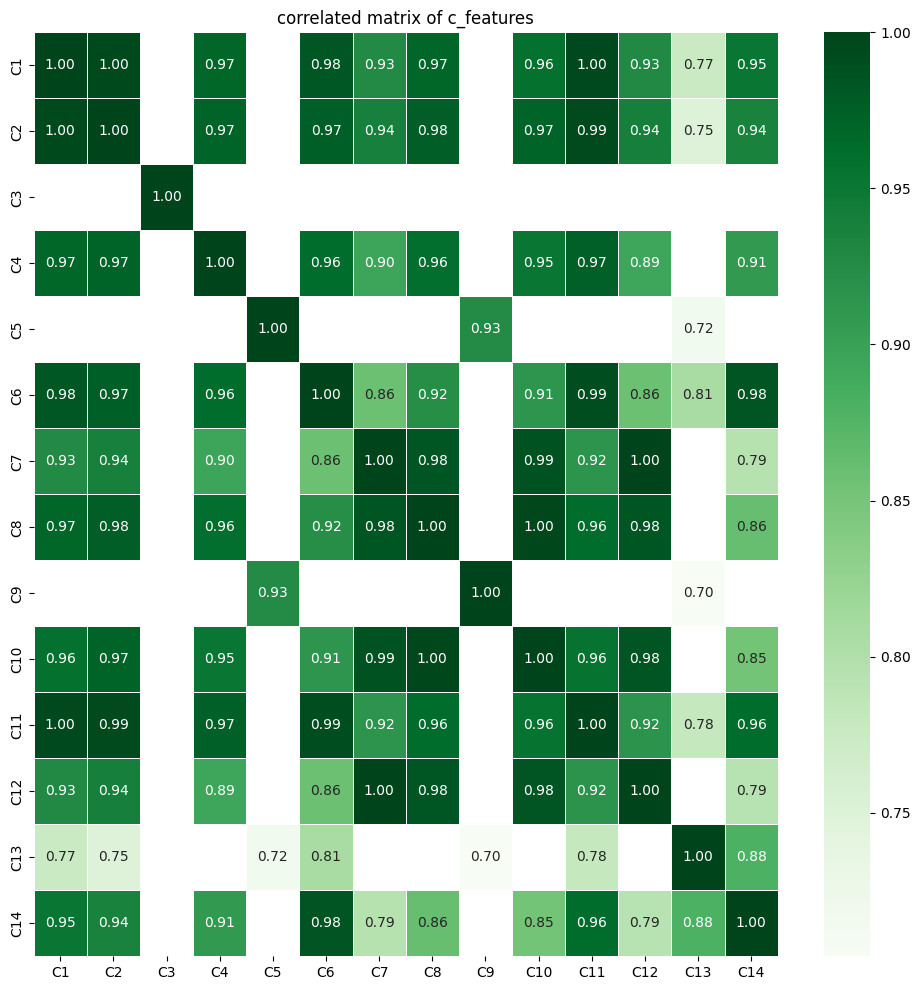

In [19]:
corr = df_train[c_features].corr()
kot = corr[corr>=.70]
plt.figure(figsize=(12,12))
sns.heatmap(kot, annot = True, fmt=".2f", linewidth=.5, cmap="Greens")
print('\n')
plt.title('correlated matrix of c_features')
plt.show()

Despite the strong correlation between C_features, we won't immediately eliminate them. Later, we'll decide whether or not to get rid of them.

Correlation analysis: D features

In [20]:
d_features = ['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7','D8', 'D9', 'D10', 'D11','D12', 'D13', 'D14', 'D15']

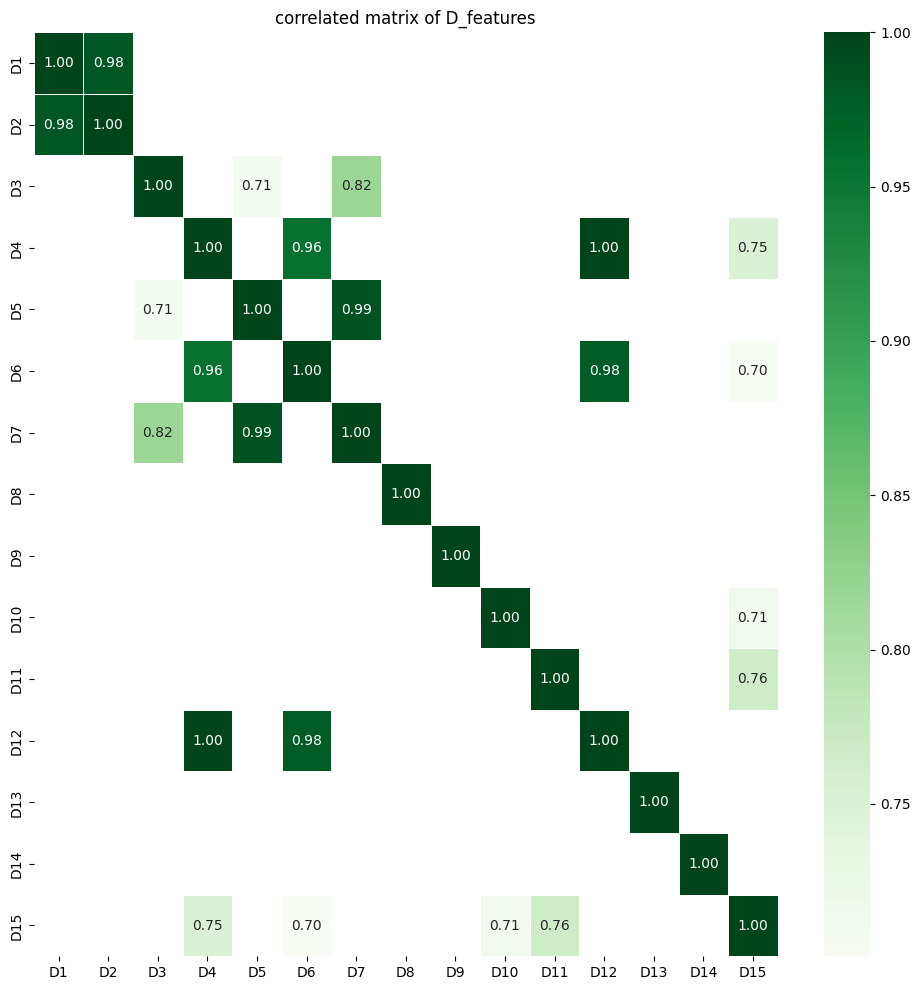

In [21]:
corr = df_train[d_features].corr()
kot = corr[corr>=.70]
plt.figure(figsize=(12,12))
sns.heatmap(kot, annot = True, fmt=".2f", linewidth=.5, cmap="Greens")
print('\n')
plt.title('correlated matrix of D_features')
plt.show()

__Observation:__

Following Inferences can be made from the above plot,

1. There appears to be little correlation among the D_features. Since D_features correlate to timedelta from the prior transactions and can be used to determine the identity of the card holder, we won't be removing these from the dataset.

Correlation analysis: Numerical id features

In [22]:
id_num_features = ['id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 'id_09', 'id_10', 'id_11']

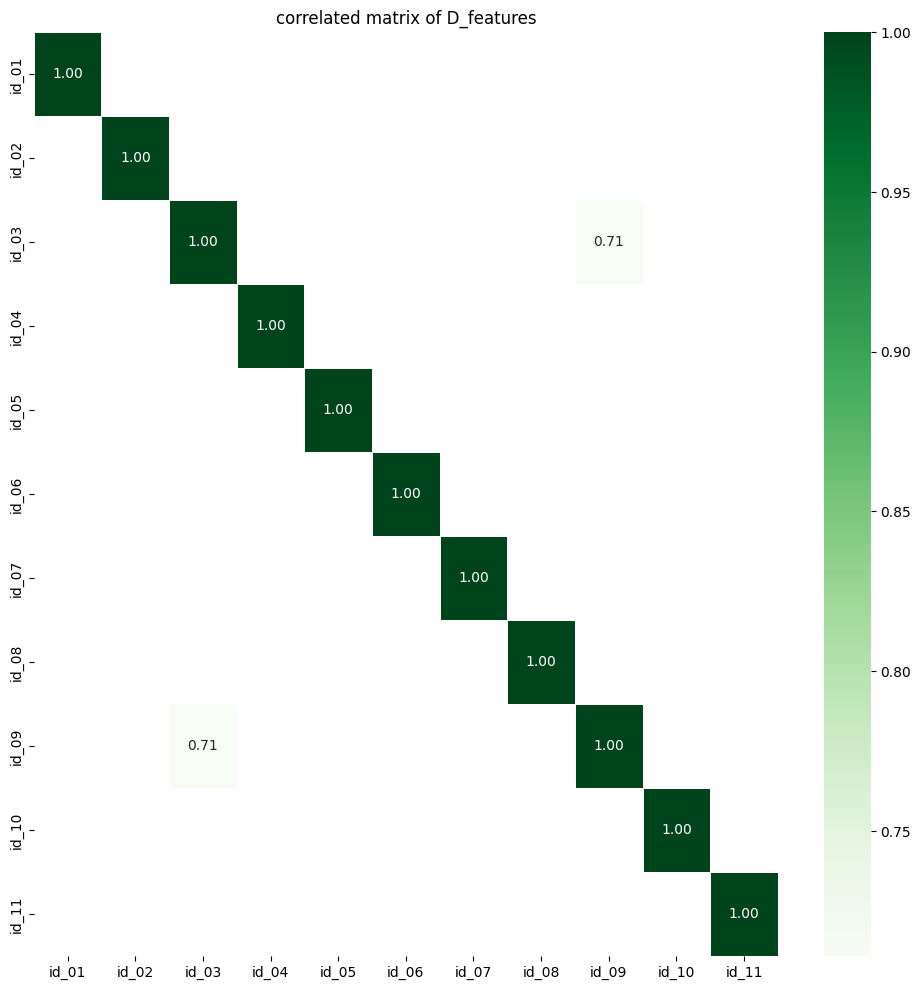

In [23]:
corr = df_train[id_num_features].corr()
kot = corr[corr>=.70]
plt.figure(figsize=(12,12))
sns.heatmap(kot, annot = True, fmt=".2f", linewidth=.5, cmap="Greens")
print('\n')
plt.title('correlated matrix of D_features')
plt.show()

__Observation(s):__

Following Inferences can be made from the above plot,

1. No id_num_feature doesn't appear to have a strong correlation. 

Correlation analysis: V features

In [24]:
v_features = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 
              'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 
              'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 
              'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 
              'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 
              'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 
              'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 
              'V89', 'V90', 'V91', 'V92', 'V93', 'V94', 'V95', 'V96', 'V97', 'V98', 'V99', 'V100', 'V101', 
              'V102', 'V103', 'V104', 'V105', 'V106', 'V107','V108', 'V109', 'V110', 'V111', 'V112', 'V113', 'V114', 
              'V115', 'V116', 'V117', 'V118', 'V119', 'V120', 'V121', 'V122', 'V123', 'V124', 'V125', 'V126', 
              'V127', 'V128', 'V129', 'V130', 'V131', 'V132', 'V133', 'V134', 'V135', 'V136', 'V137', 'V138', 
              'V139', 'V140', 'V141', 'V142', 'V143', 'V144', 'V145', 'V146', 'V147', 'V148', 'V149', 'V150', 
              'V151', 'V152', 'V153', 'V154', 'V155', 'V156', 'V157', 'V158', 'V159', 'V160', 'V161', 'V162', 
              'V163', 'V164', 'V165', 'V166', 'V167', 'V168', 'V169', 'V170', 'V171', 'V172', 'V173', 'V174', 
              'V175', 'V176', 'V177', 'V178', 'V179', 'V180', 'V181', 'V182', 'V183', 'V184', 'V185', 'V186', 
              'V187', 'V188', 'V189', 'V190', 'V191', 'V192', 'V193', 'V194', 'V195', 'V196', 'V197', 'V198', 
              'V199', 'V200', 'V201', 'V202', 'V203', 'V204', 'V205', 'V206', 'V207', 'V208', 'V209', 'V210', 
              'V211', 'V212', 'V213', 'V214', 'V215', 'V216', 'V217', 'V218', 'V219', 'V220', 'V221', 'V222', 
              'V223', 'V224', 'V225', 'V226', 'V227', 'V228', 'V229', 'V230', 'V231', 'V232', 'V233', 'V234', 
              'V235', 'V236', 'V237', 'V238', 'V239', 'V240', 'V241', 'V242', 'V243', 'V244', 'V245', 'V246', 
              'V247', 'V248', 'V249', 'V250', 'V251', 'V252', 'V253', 'V254', 'V255', 'V256', 'V257', 'V258', 
              'V259', 'V260', 'V261', 'V262', 'V263', 'V264', 'V265', 'V266', 'V267', 'V268', 'V269', 'V270', 
              'V271', 'V272', 'V273', 'V274', 'V275', 'V276', 'V277', 'V278', 'V279', 'V280', 'V281', 'V282', 
              'V283', 'V284', 'V285', 'V286', 'V287', 'V288', 'V289', 'V290', 'V291', 'V292', 'V293', 'V294', 
              'V295', 'V296', 'V297', 'V298', 'V299', 'V300', 'V301', 'V302', 'V303', 'V304', 'V305', 'V306', 
              'V307', 'V308', 'V309', 'V310', 'V311', 'V312', 'V313', 'V314', 'V315', 'V316', 'V317', 'V318', 
              'V319', 'V320', 'V321', 'V322', 'V323', 'V324', 'V325', 'V326', 'V327', 'V328', 'V329', 'V330', 
              'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338', 'V339']

The V_features, which make up the majority of the features in our dataset, also have a significant amount of missing values. A nice pattern was discovered while conducting EDA; there were clusters of V_features that had the same number of missing values. Let's investigate this quality in greater detail to see if we can learn anything pertinent.

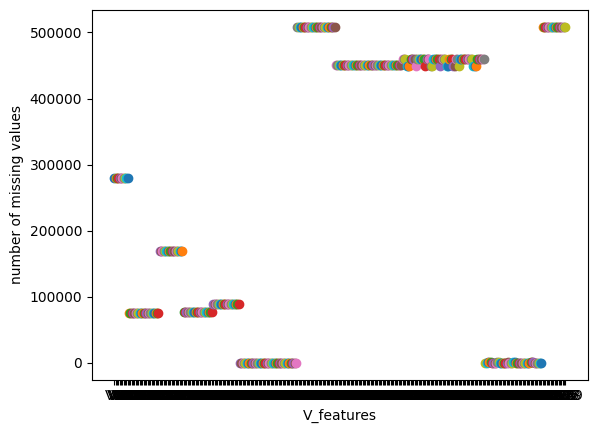

In [25]:
for key, val in df_train[v_features].isna().sum().items():
    plt.scatter(key,val)
    plt.xlabel('V_features')
    plt.ylabel('number of missing values')

In [26]:
# Based on the EDA V_features can be divided into groups with same number of missig values.

v_groups = {}

for key, val in df_train[v_features].isna().sum().items():
    if(v_groups.get(val, -1)==-1):
        v_groups[val] = [key]
    else:
        v_groups[val].append(key) 

In [27]:
# V_feature groups based on same number of missing values

for missing_count, grp in v_groups.items():
    print(f'{grp} this features has {missing_count} missing values\n')

['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11'] this features has 279287 missing values

['V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34'] this features has 76073 missing values

['V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52'] this features has 168969 missing values

['V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74'] this features has 77096 missing values

['V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94'] this features has 89164 missing values

['V95', 'V96', 'V97', 'V98', 'V99', 'V100', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V107', 'V108', 'V109', 'V110', 'V111', 'V112', 'V11

In [28]:
v_grp = list(v_groups.values())

**Observation:** In the case of V features, there is a nice pattern of missing data. Based on the quantity of missing values, V features are divided into a total of 15 categories. We will find out collinearity of V features within these categories.

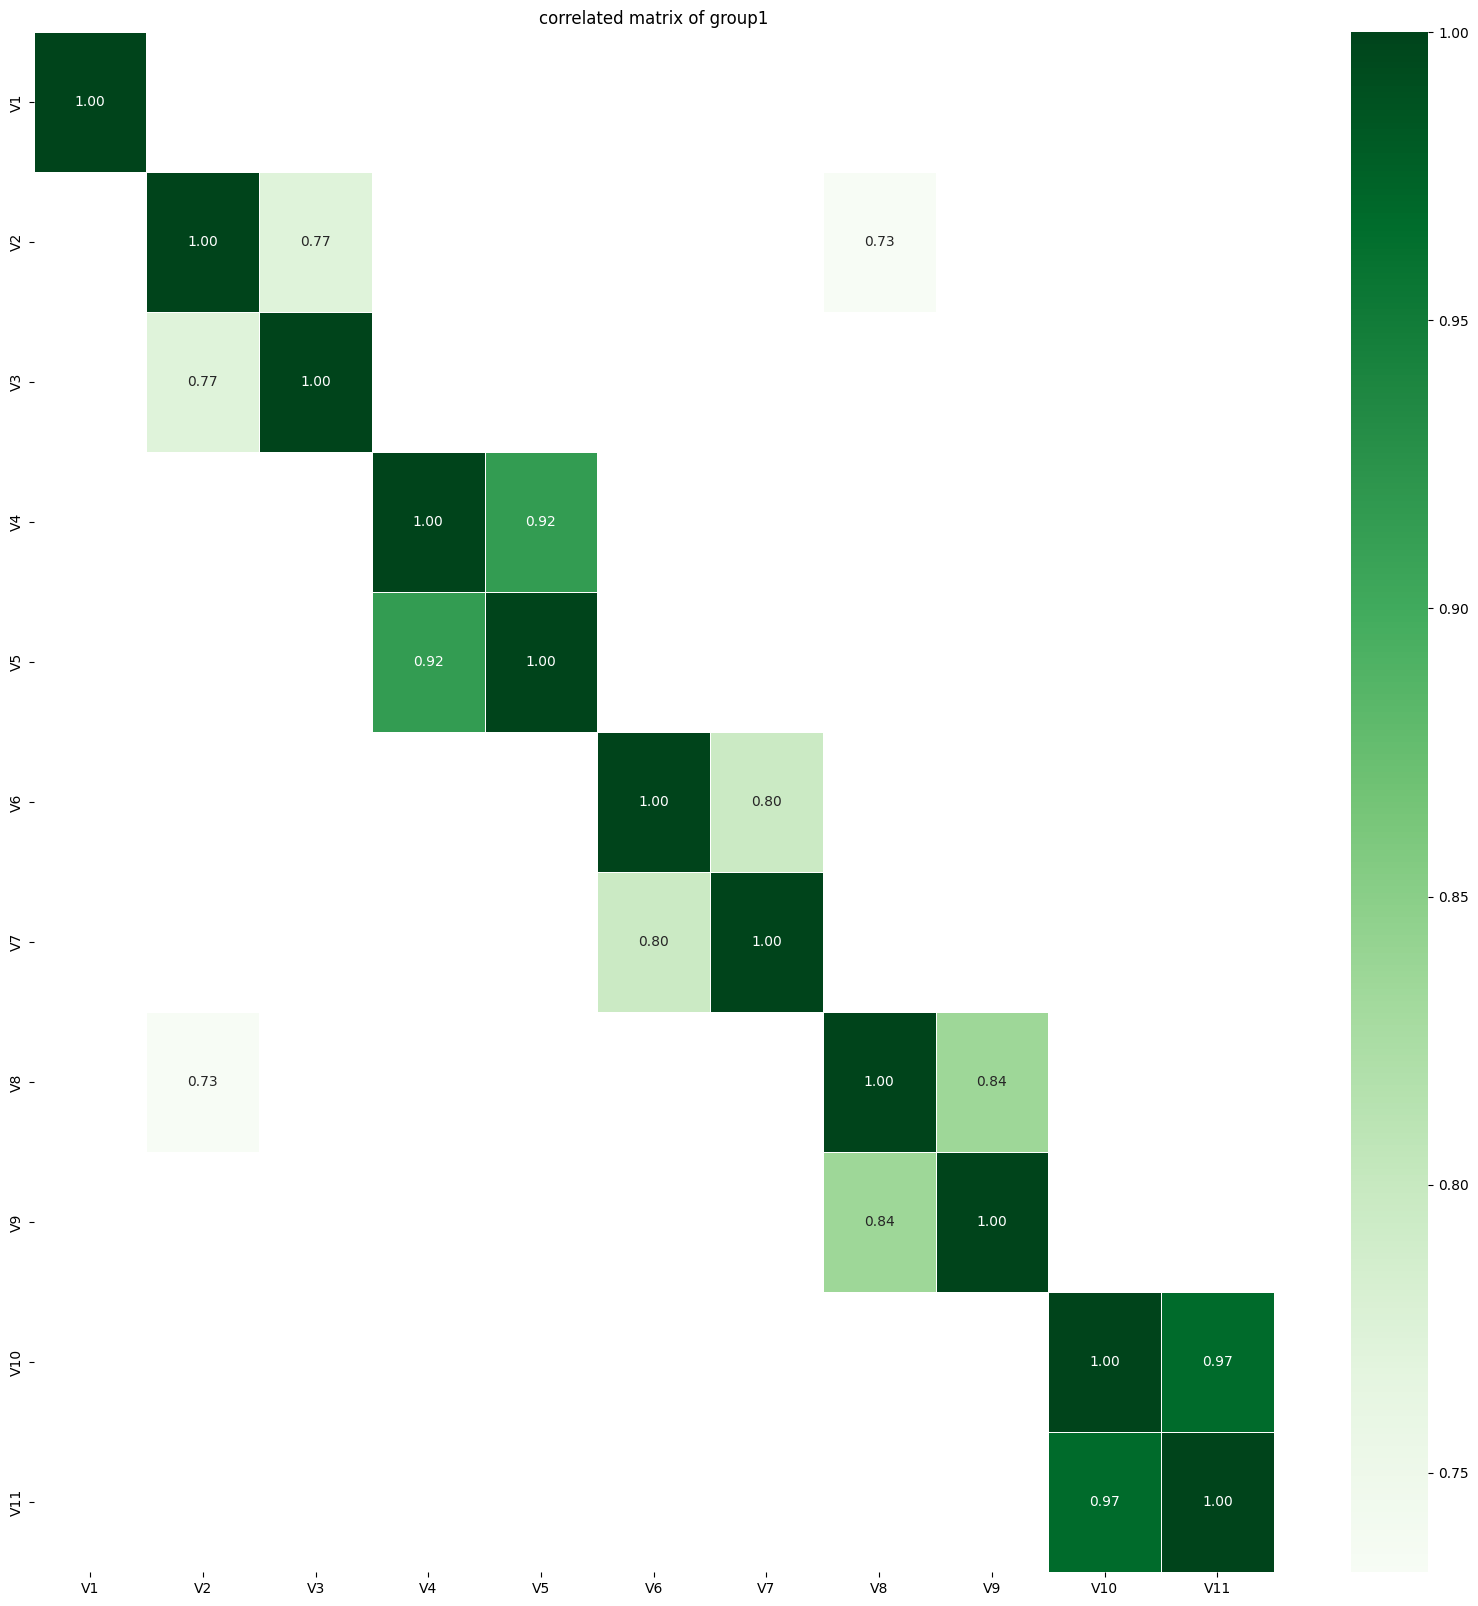

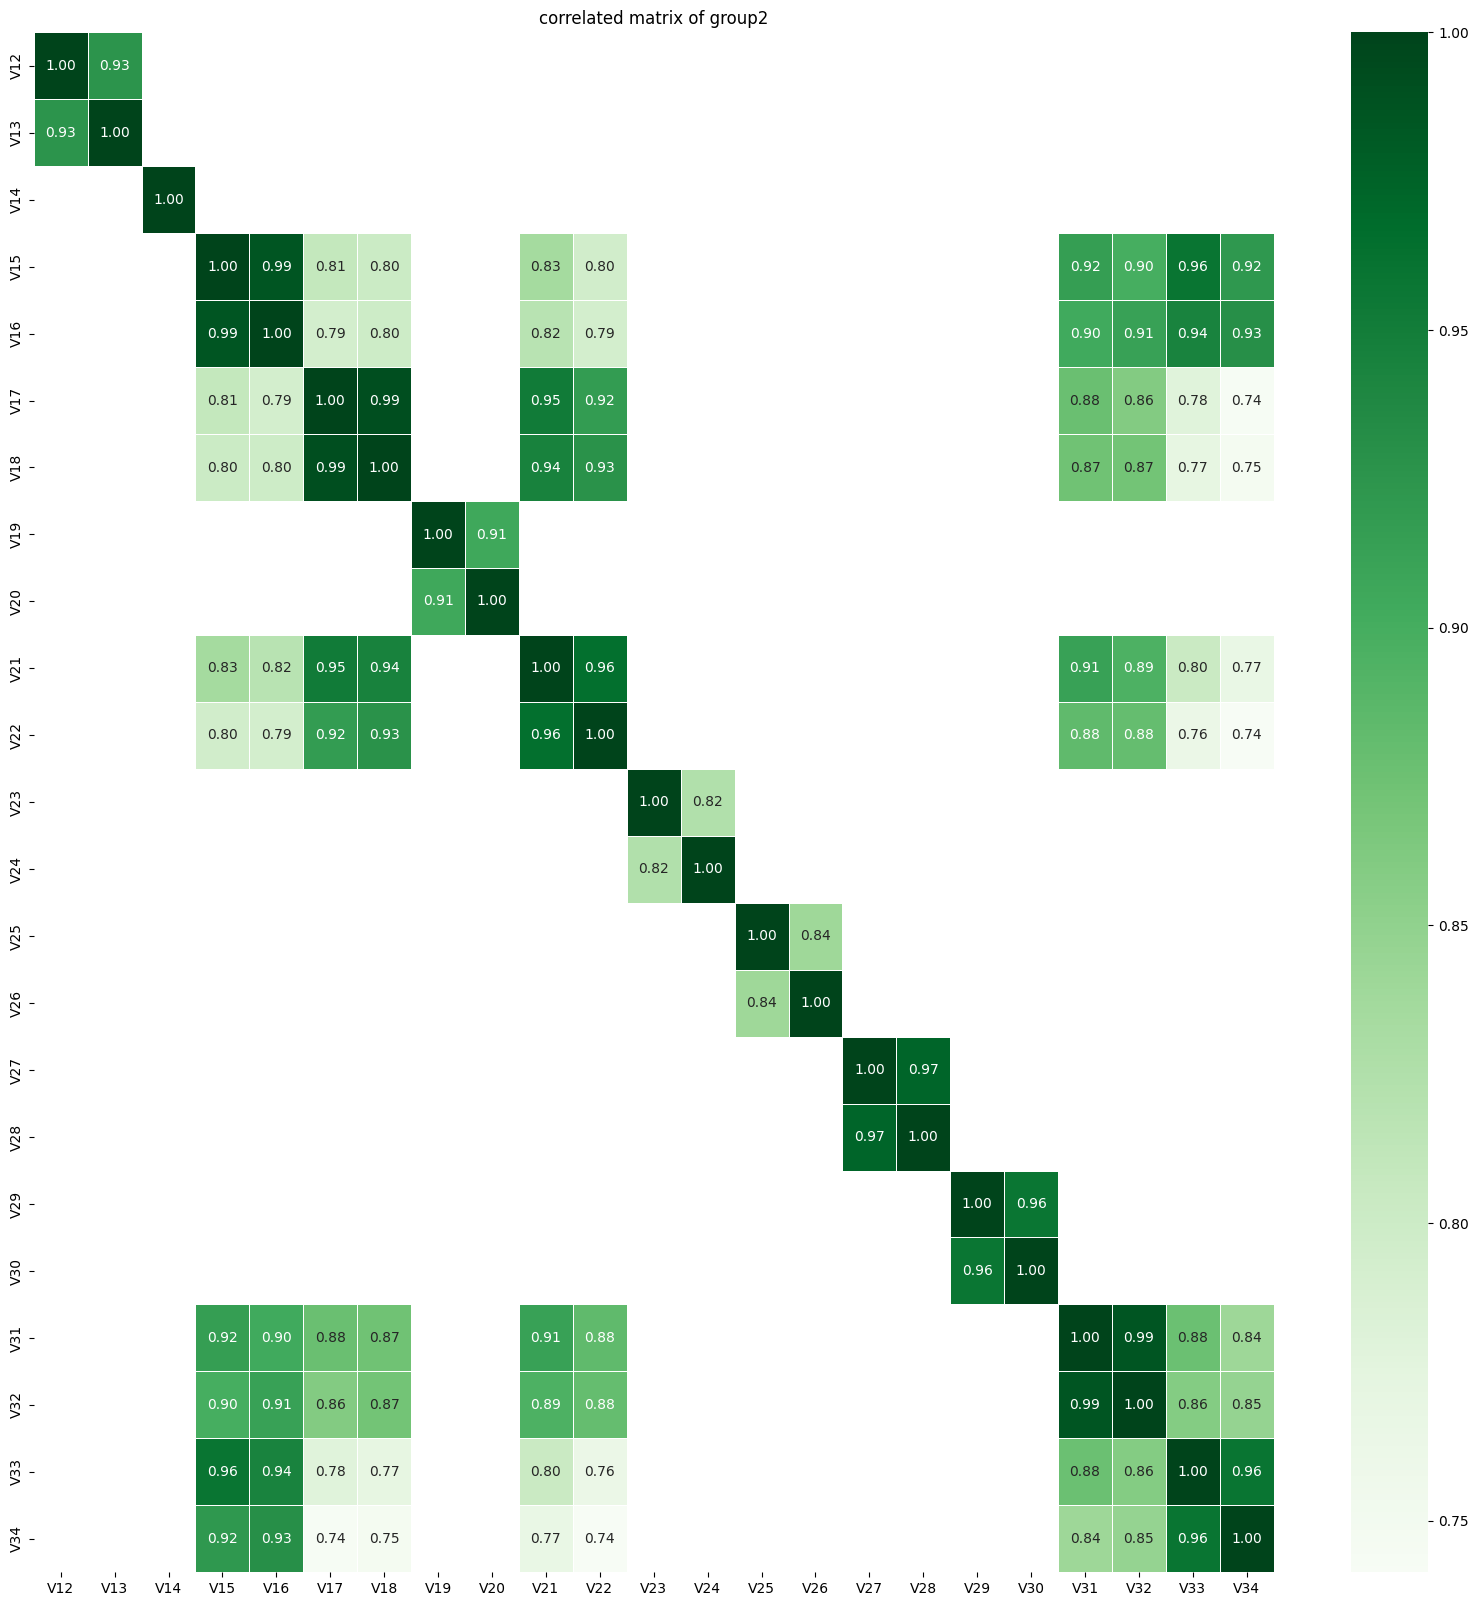

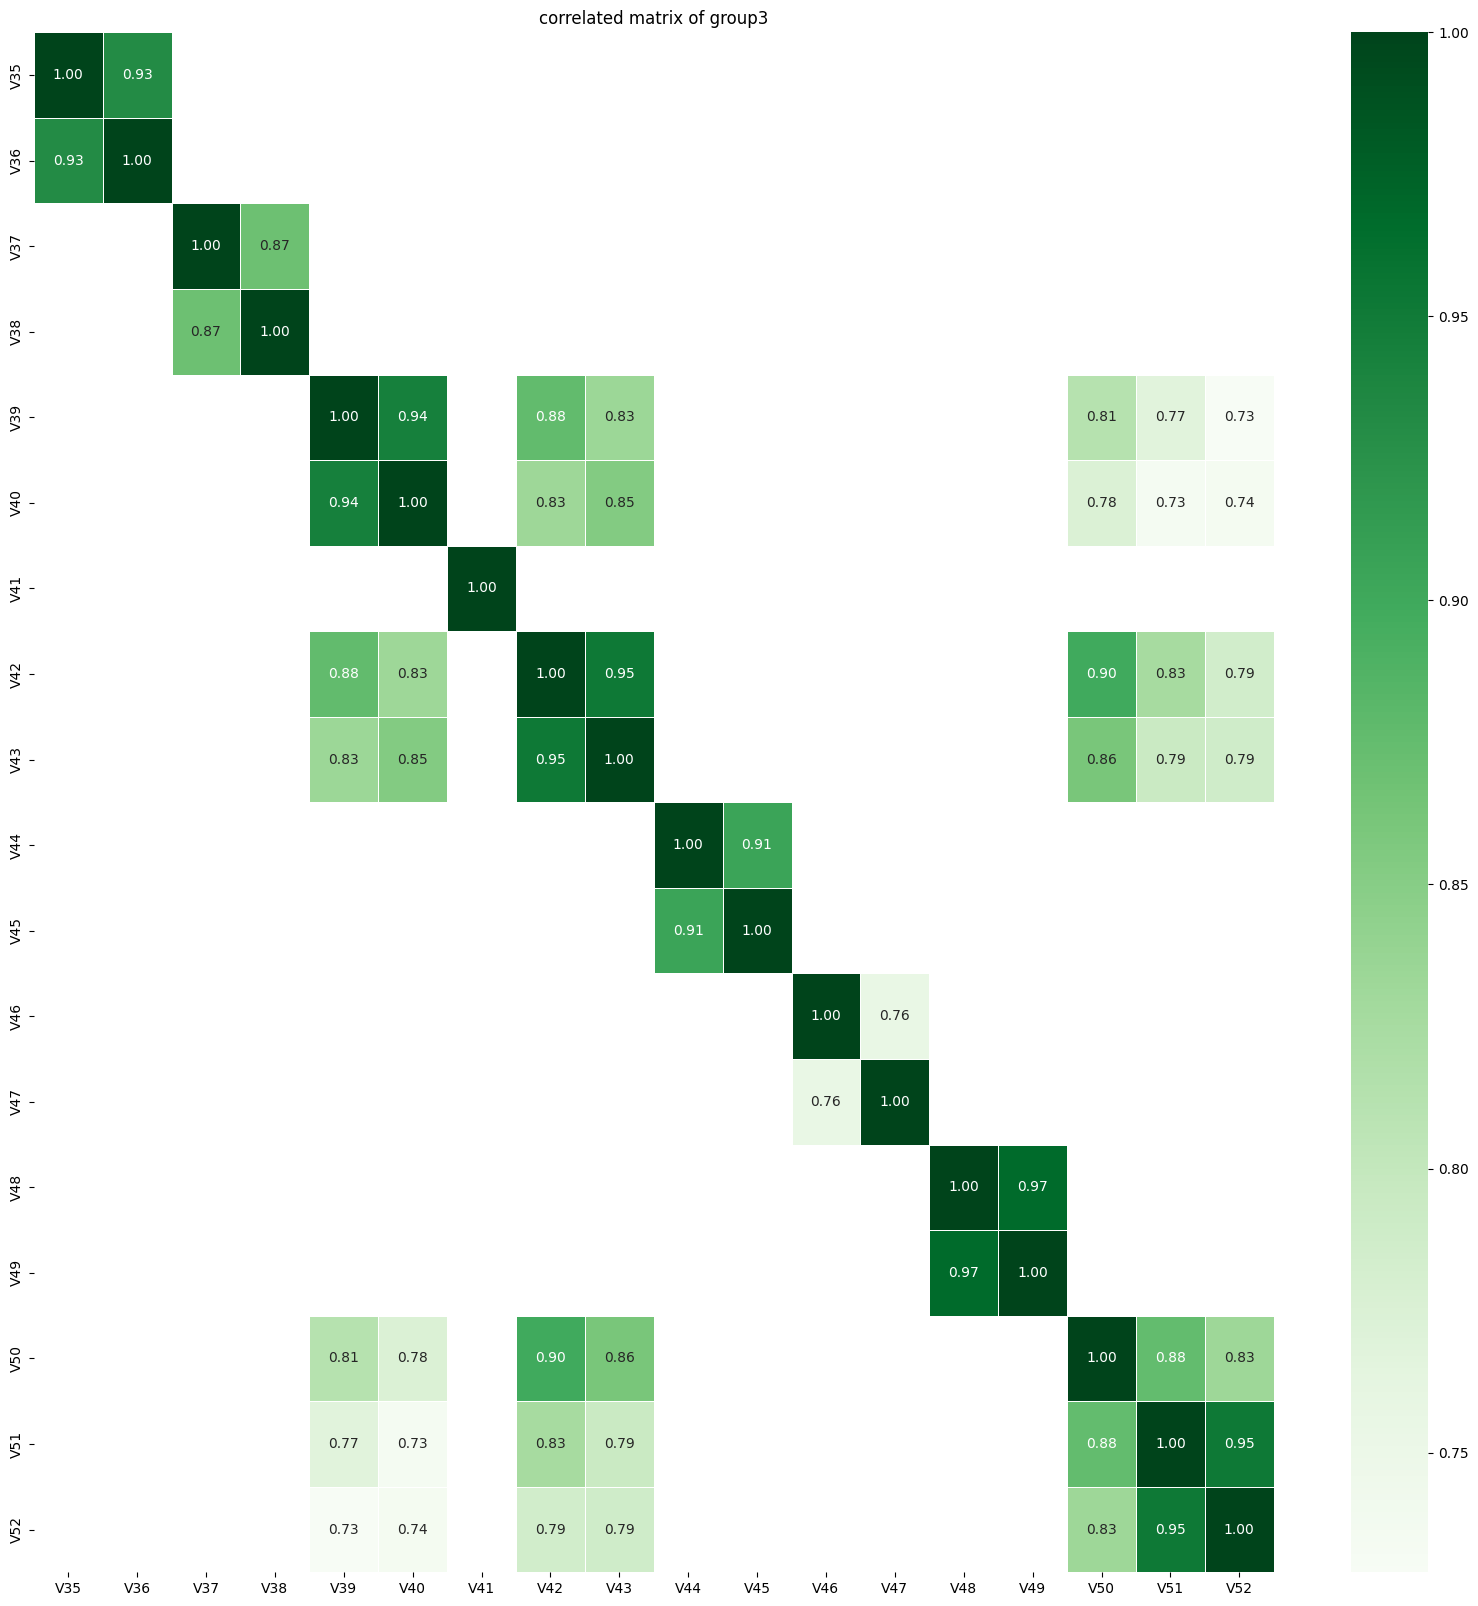

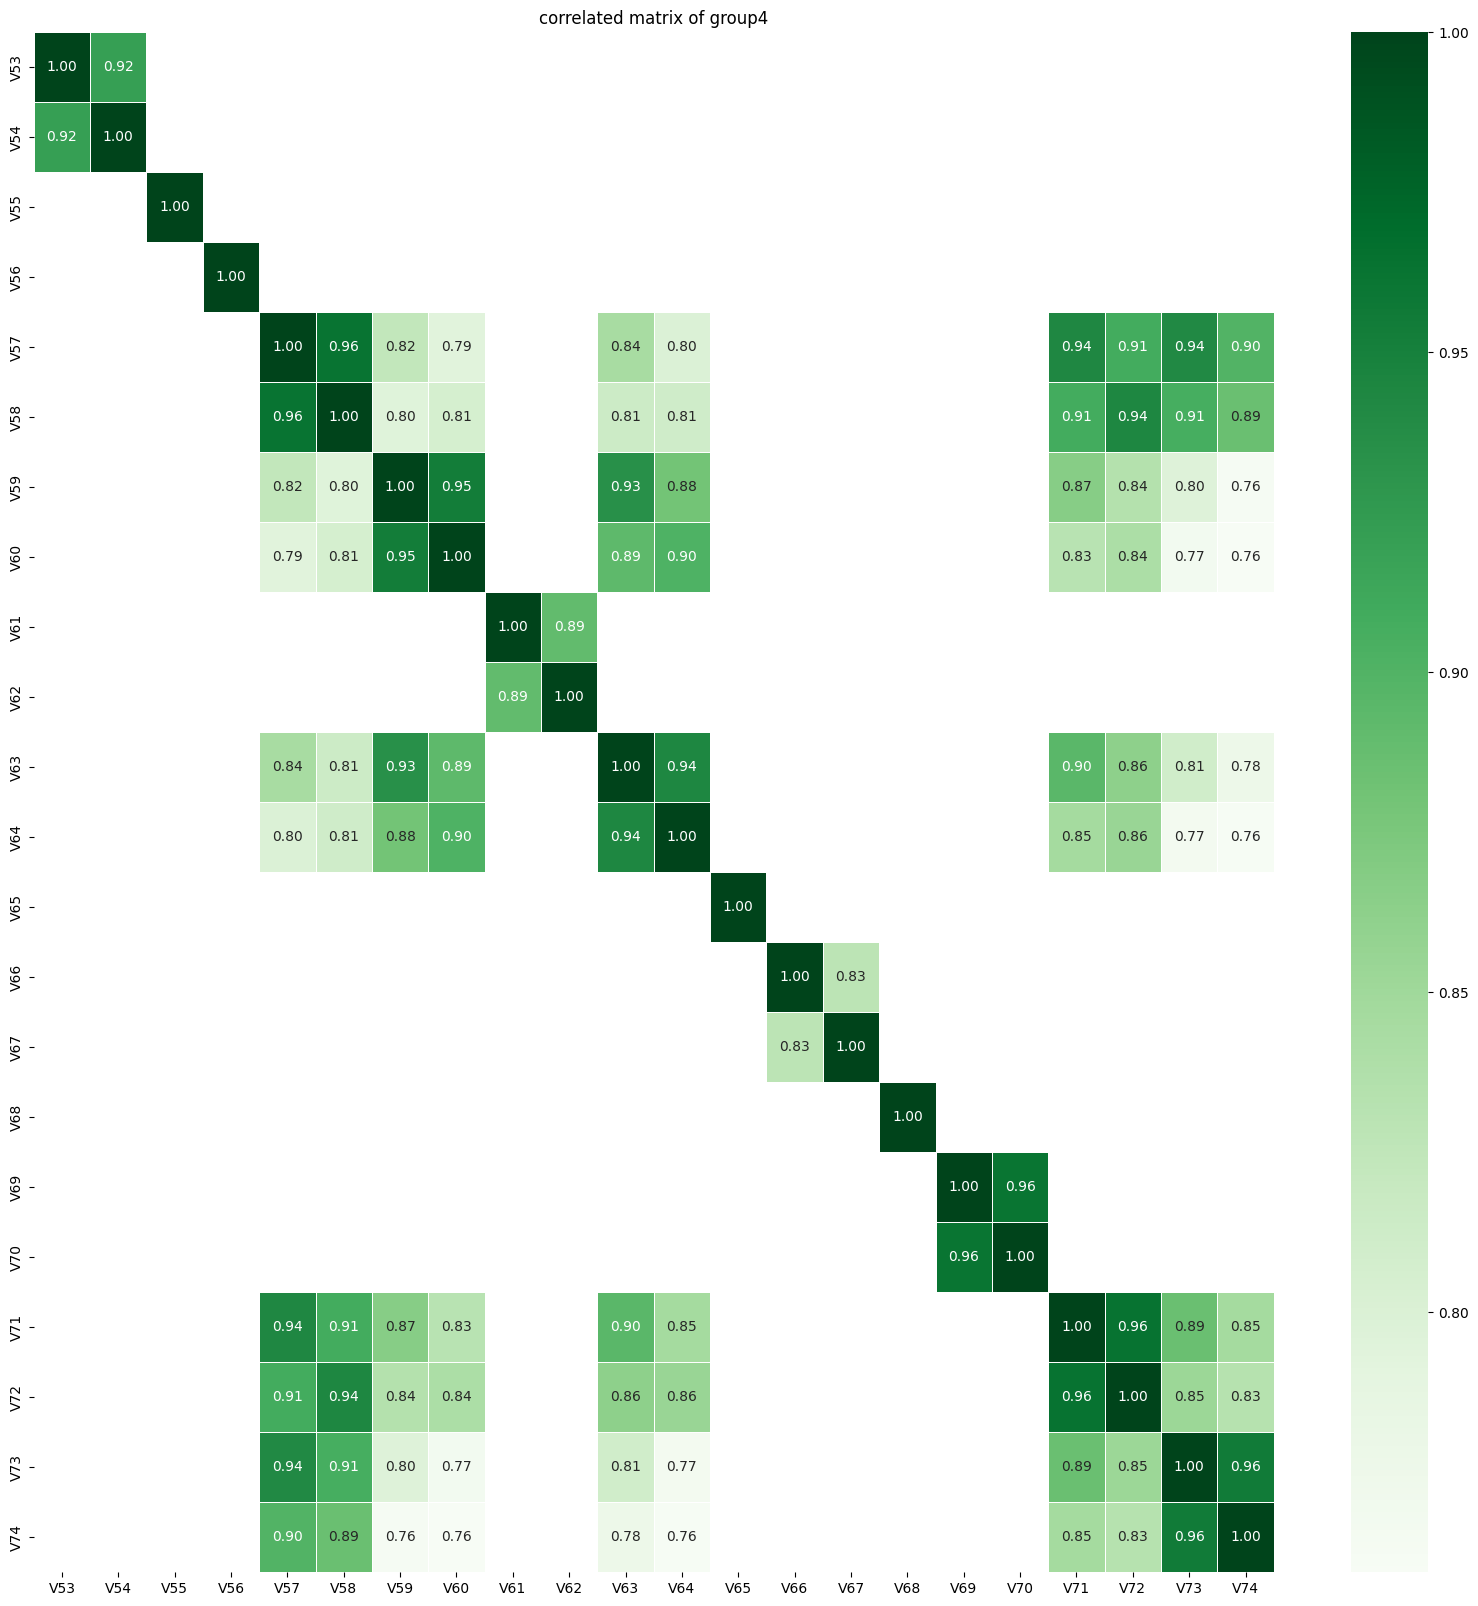

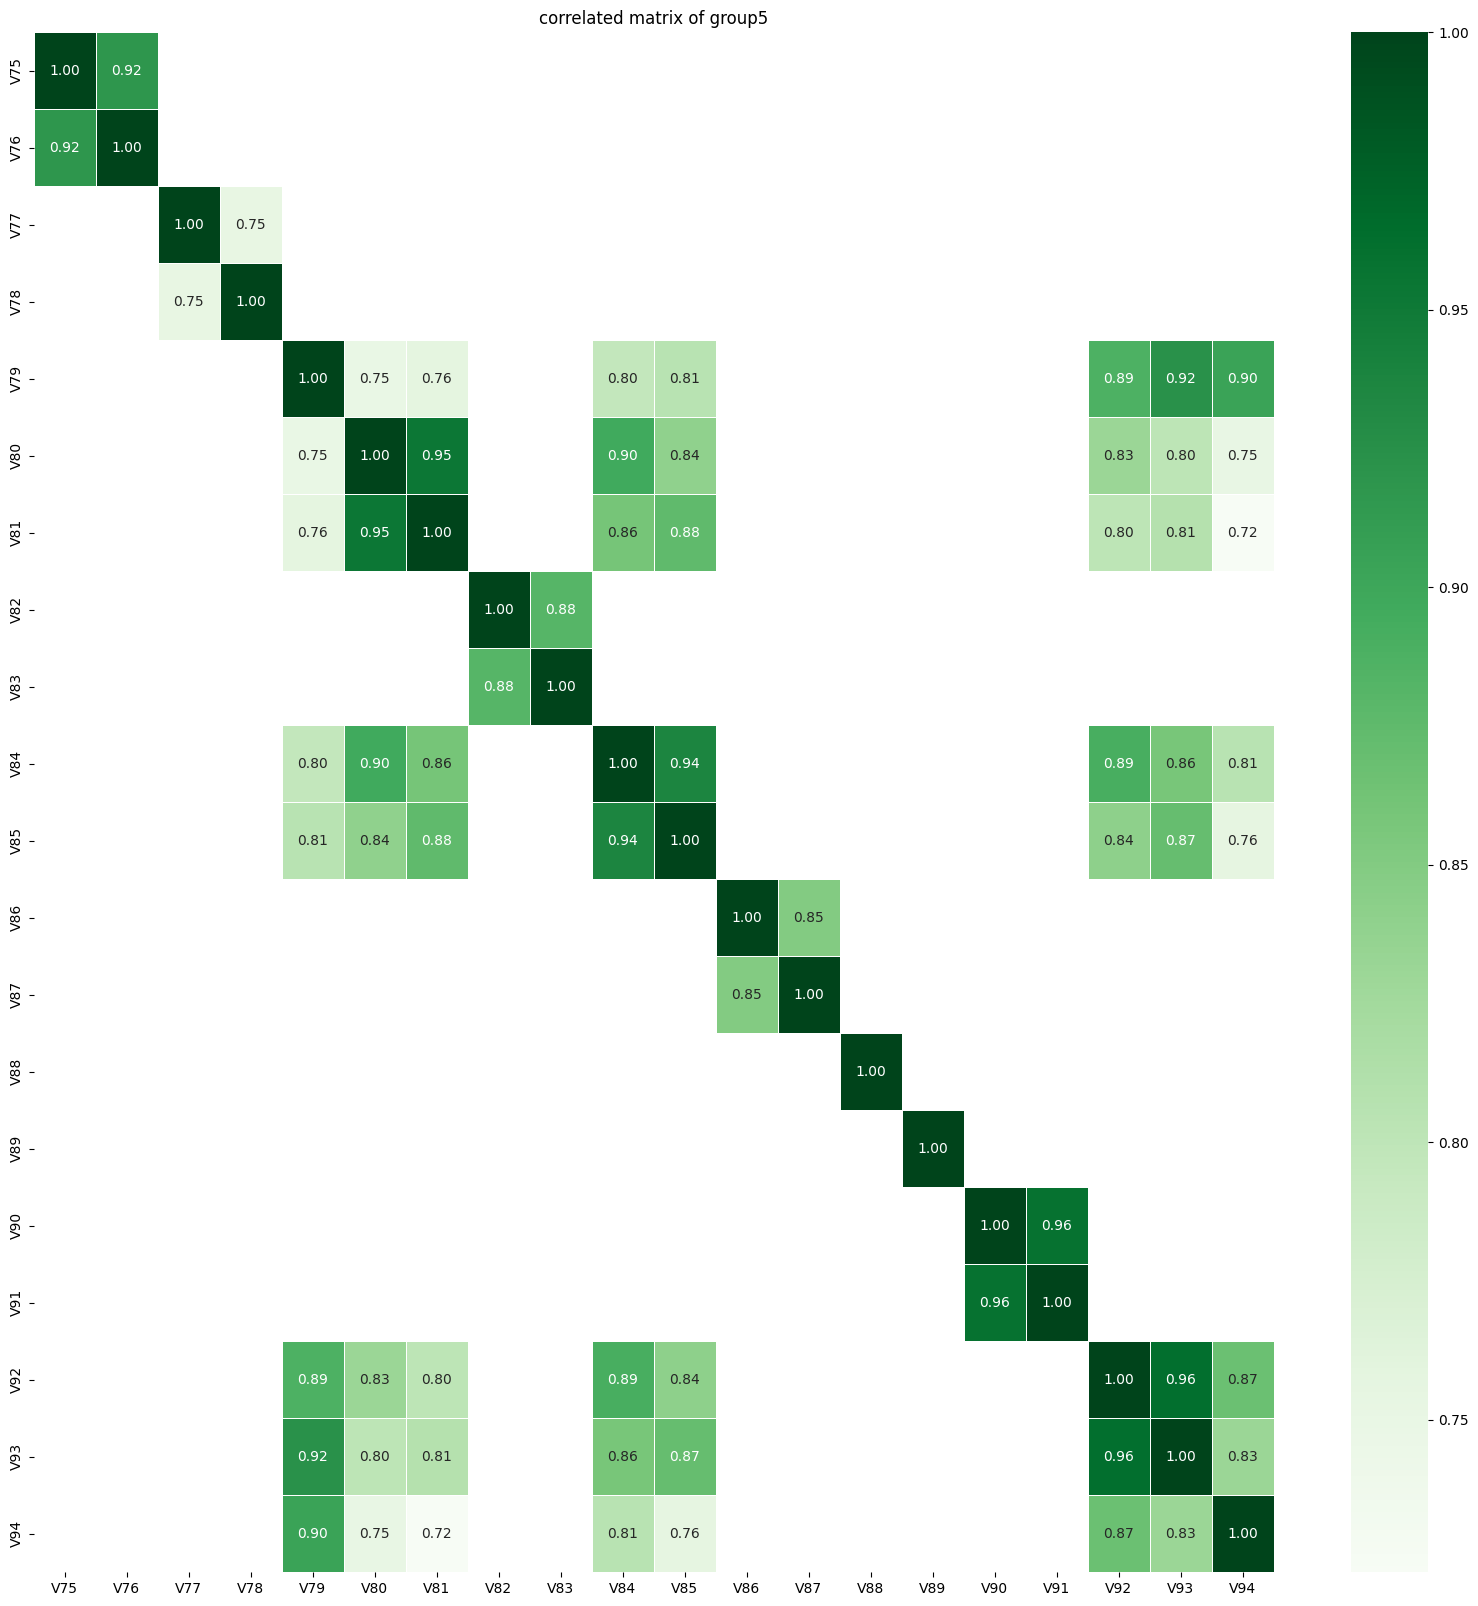

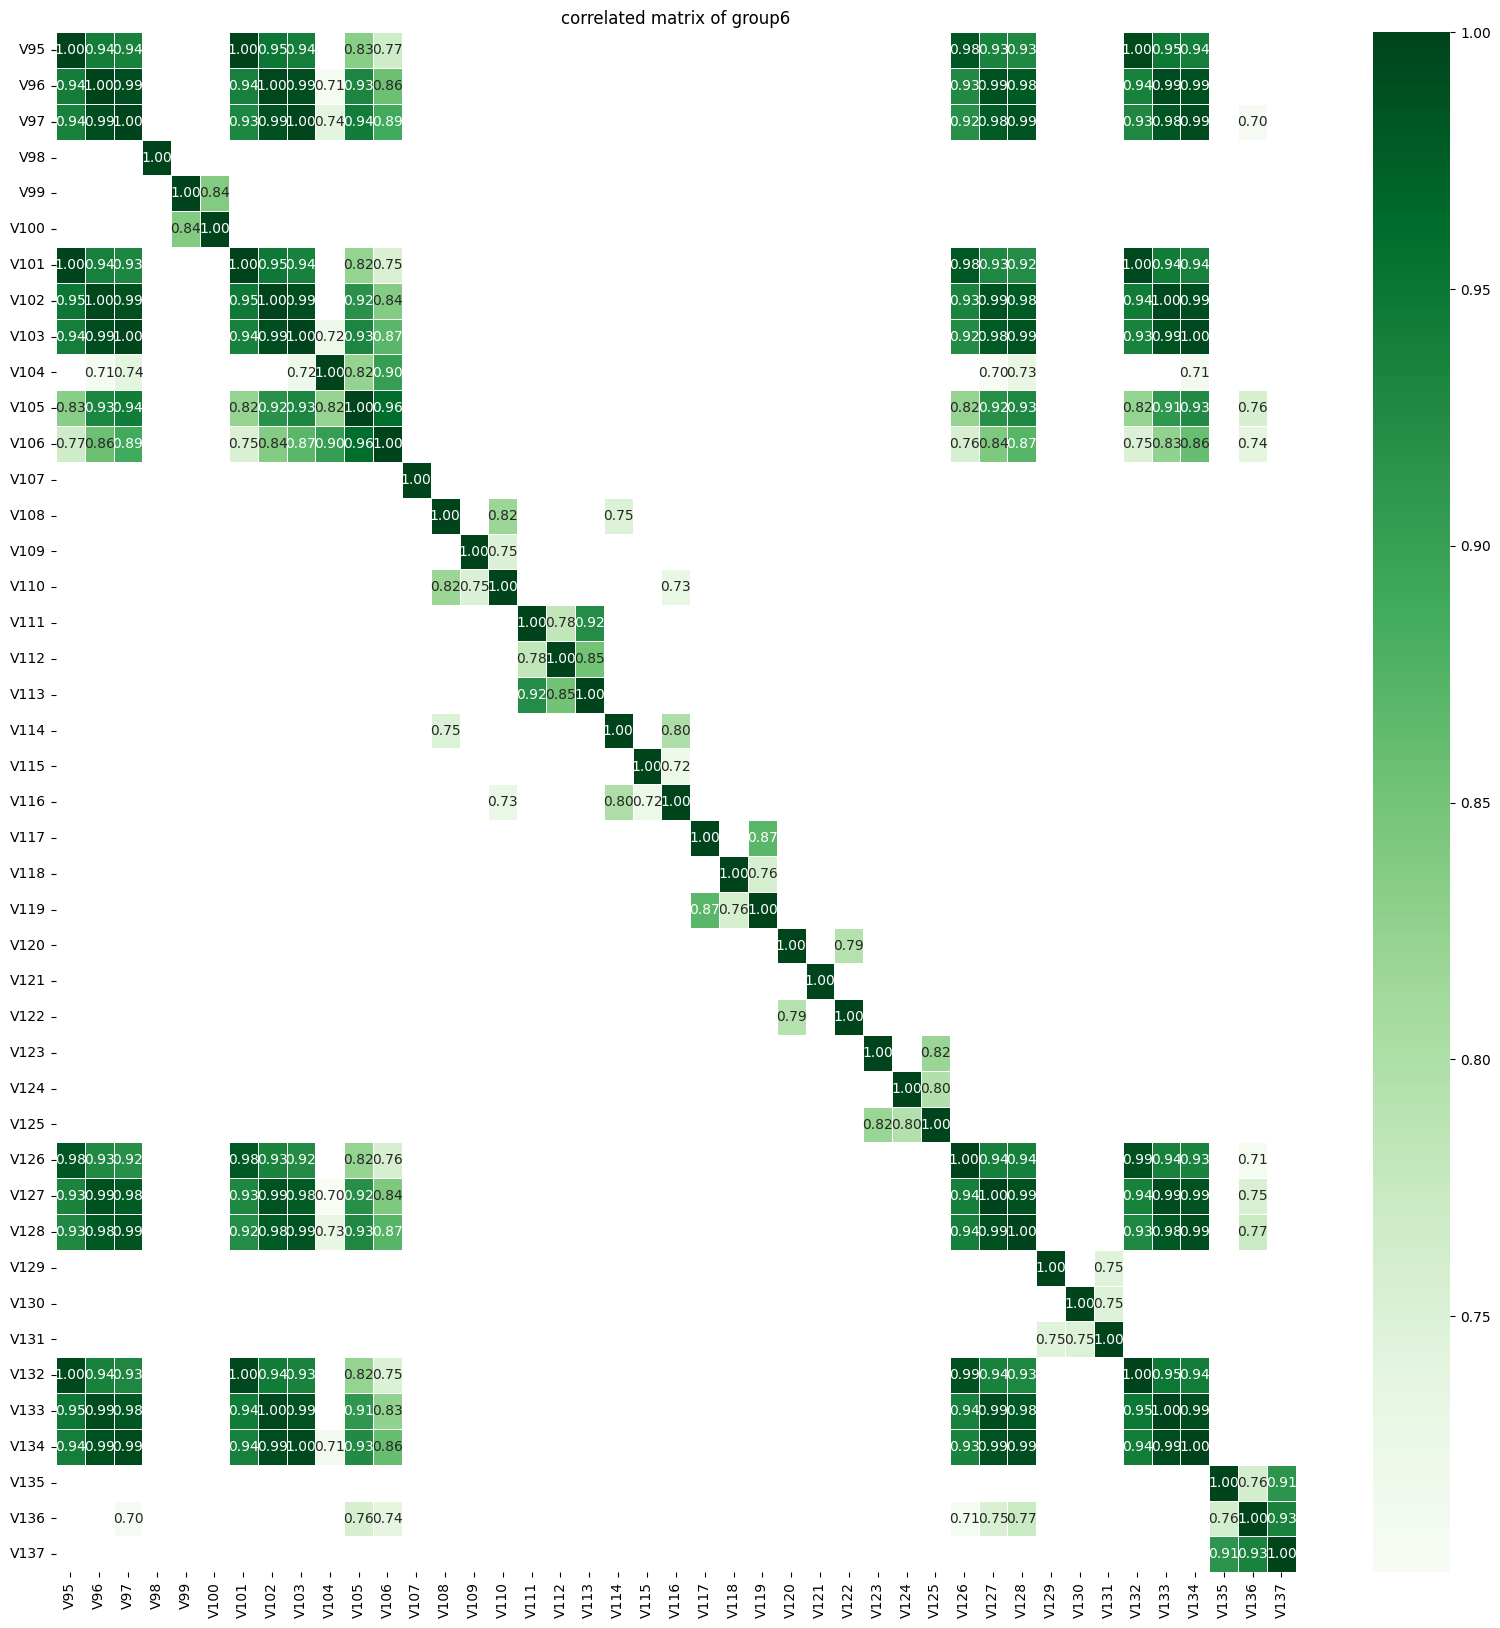

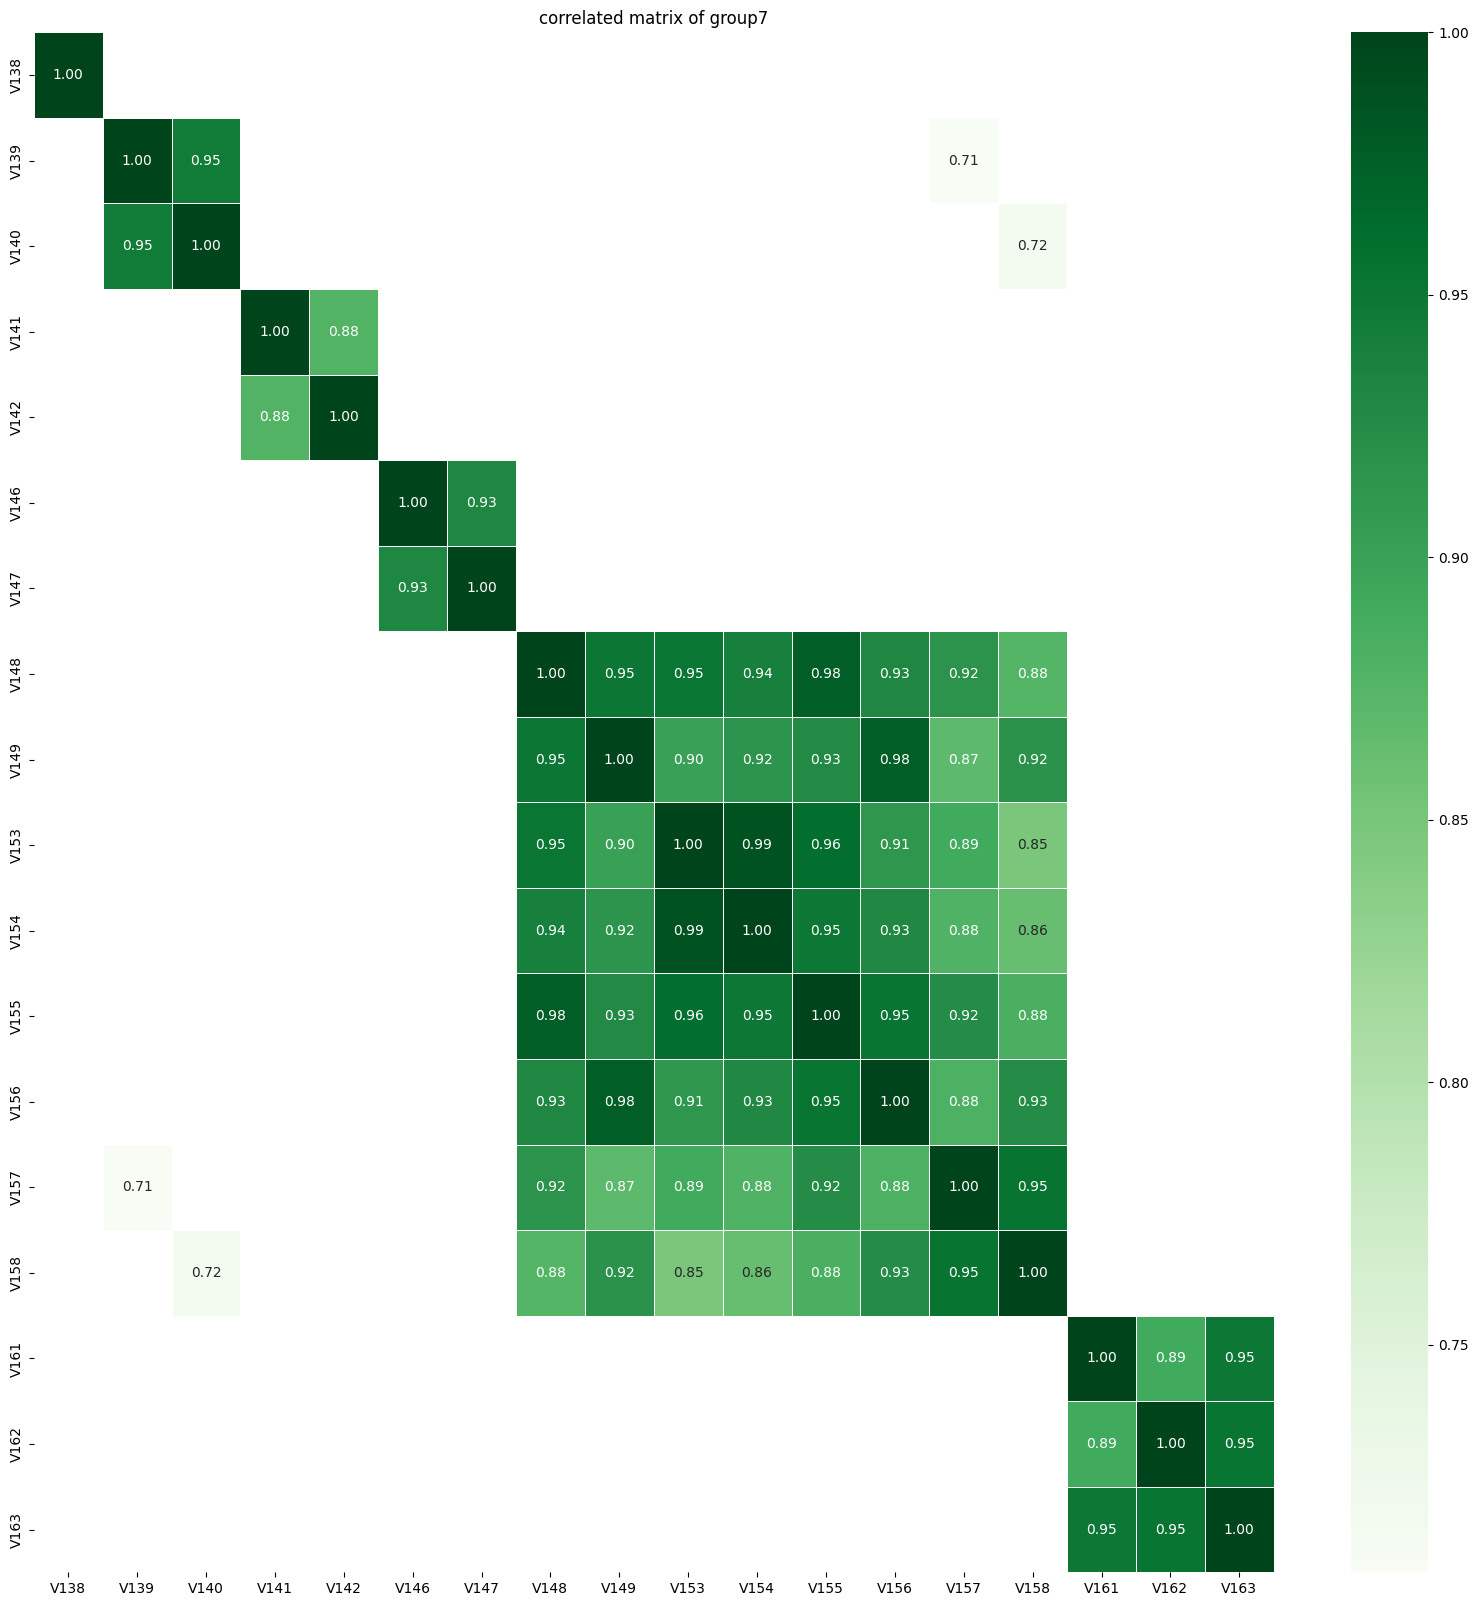

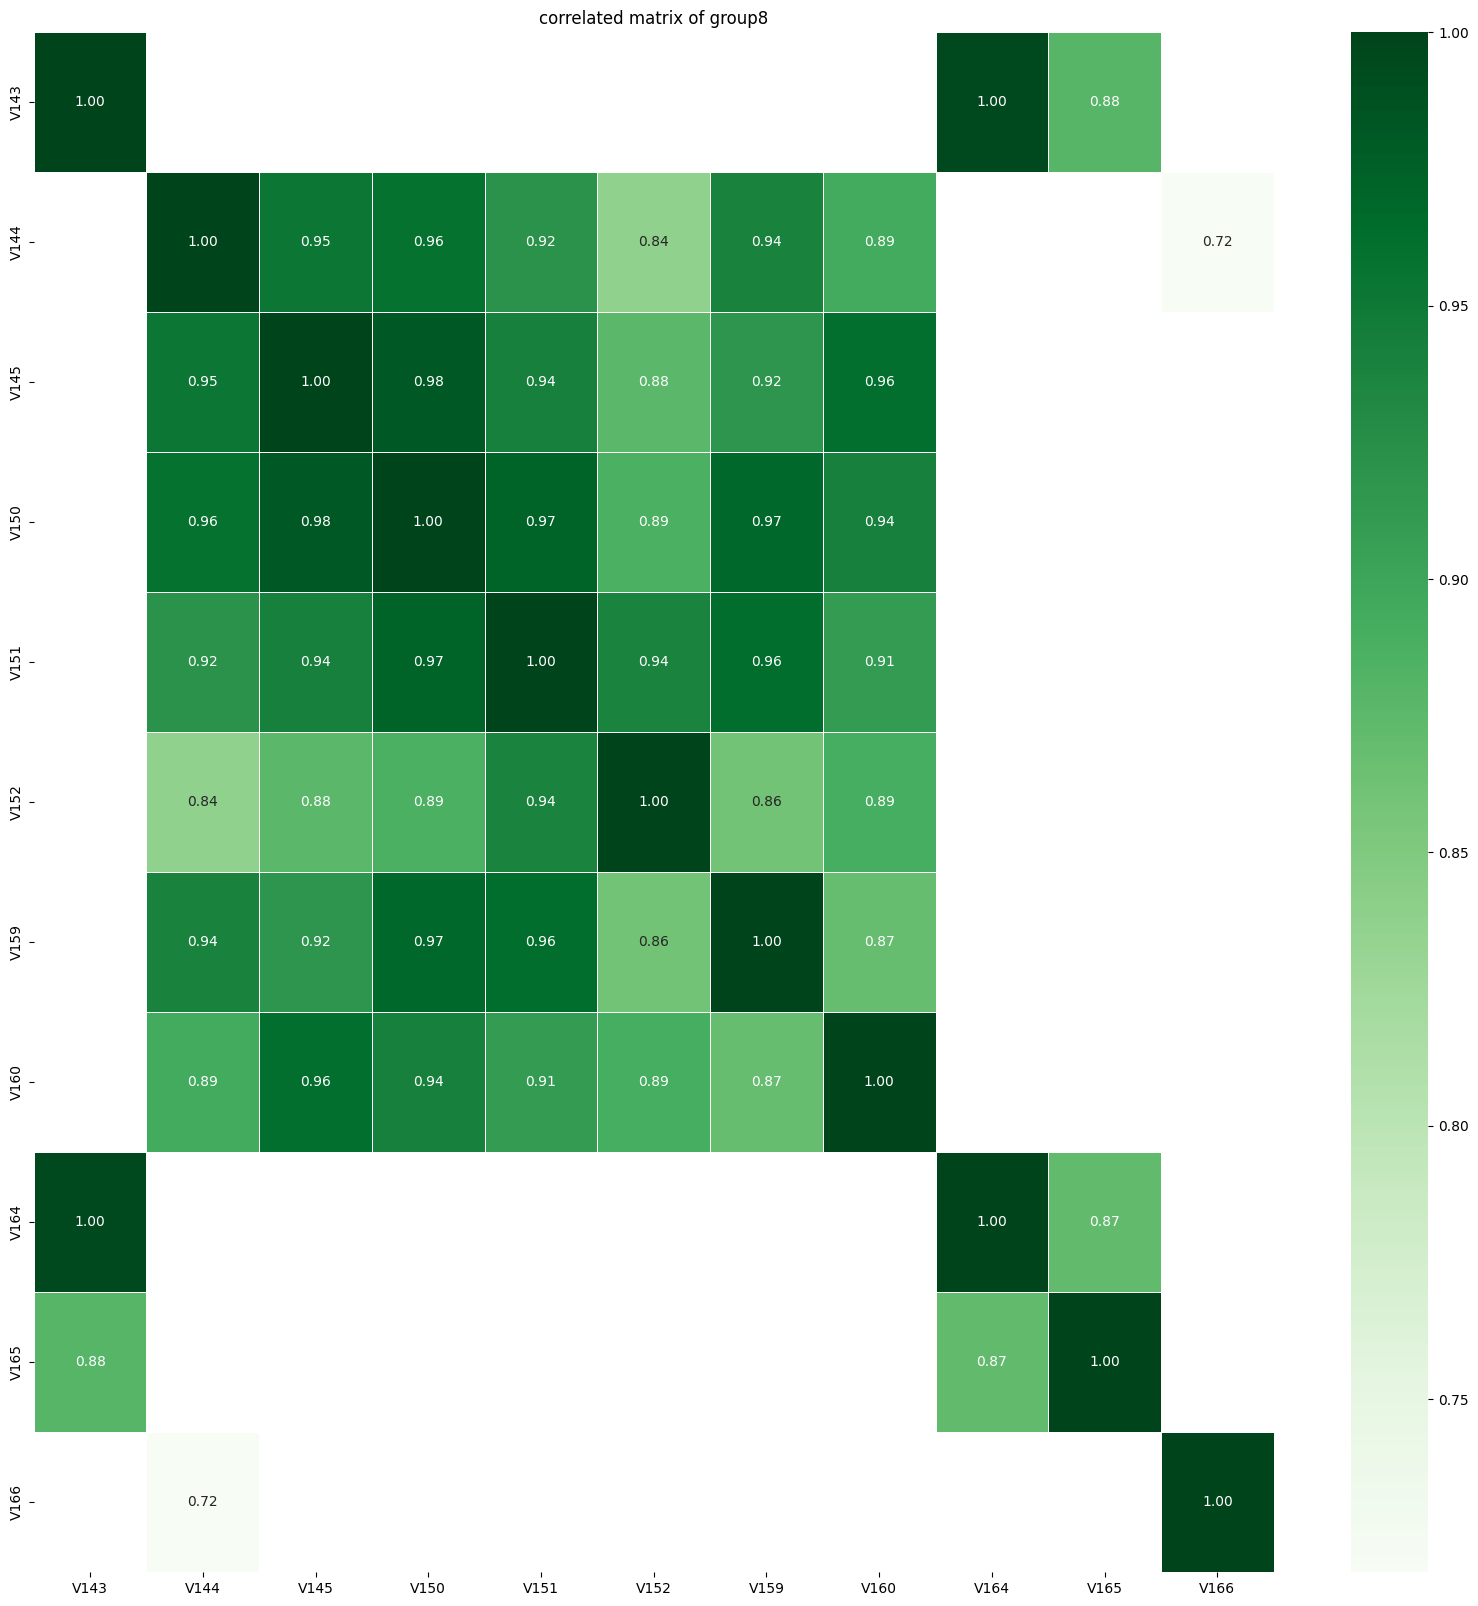

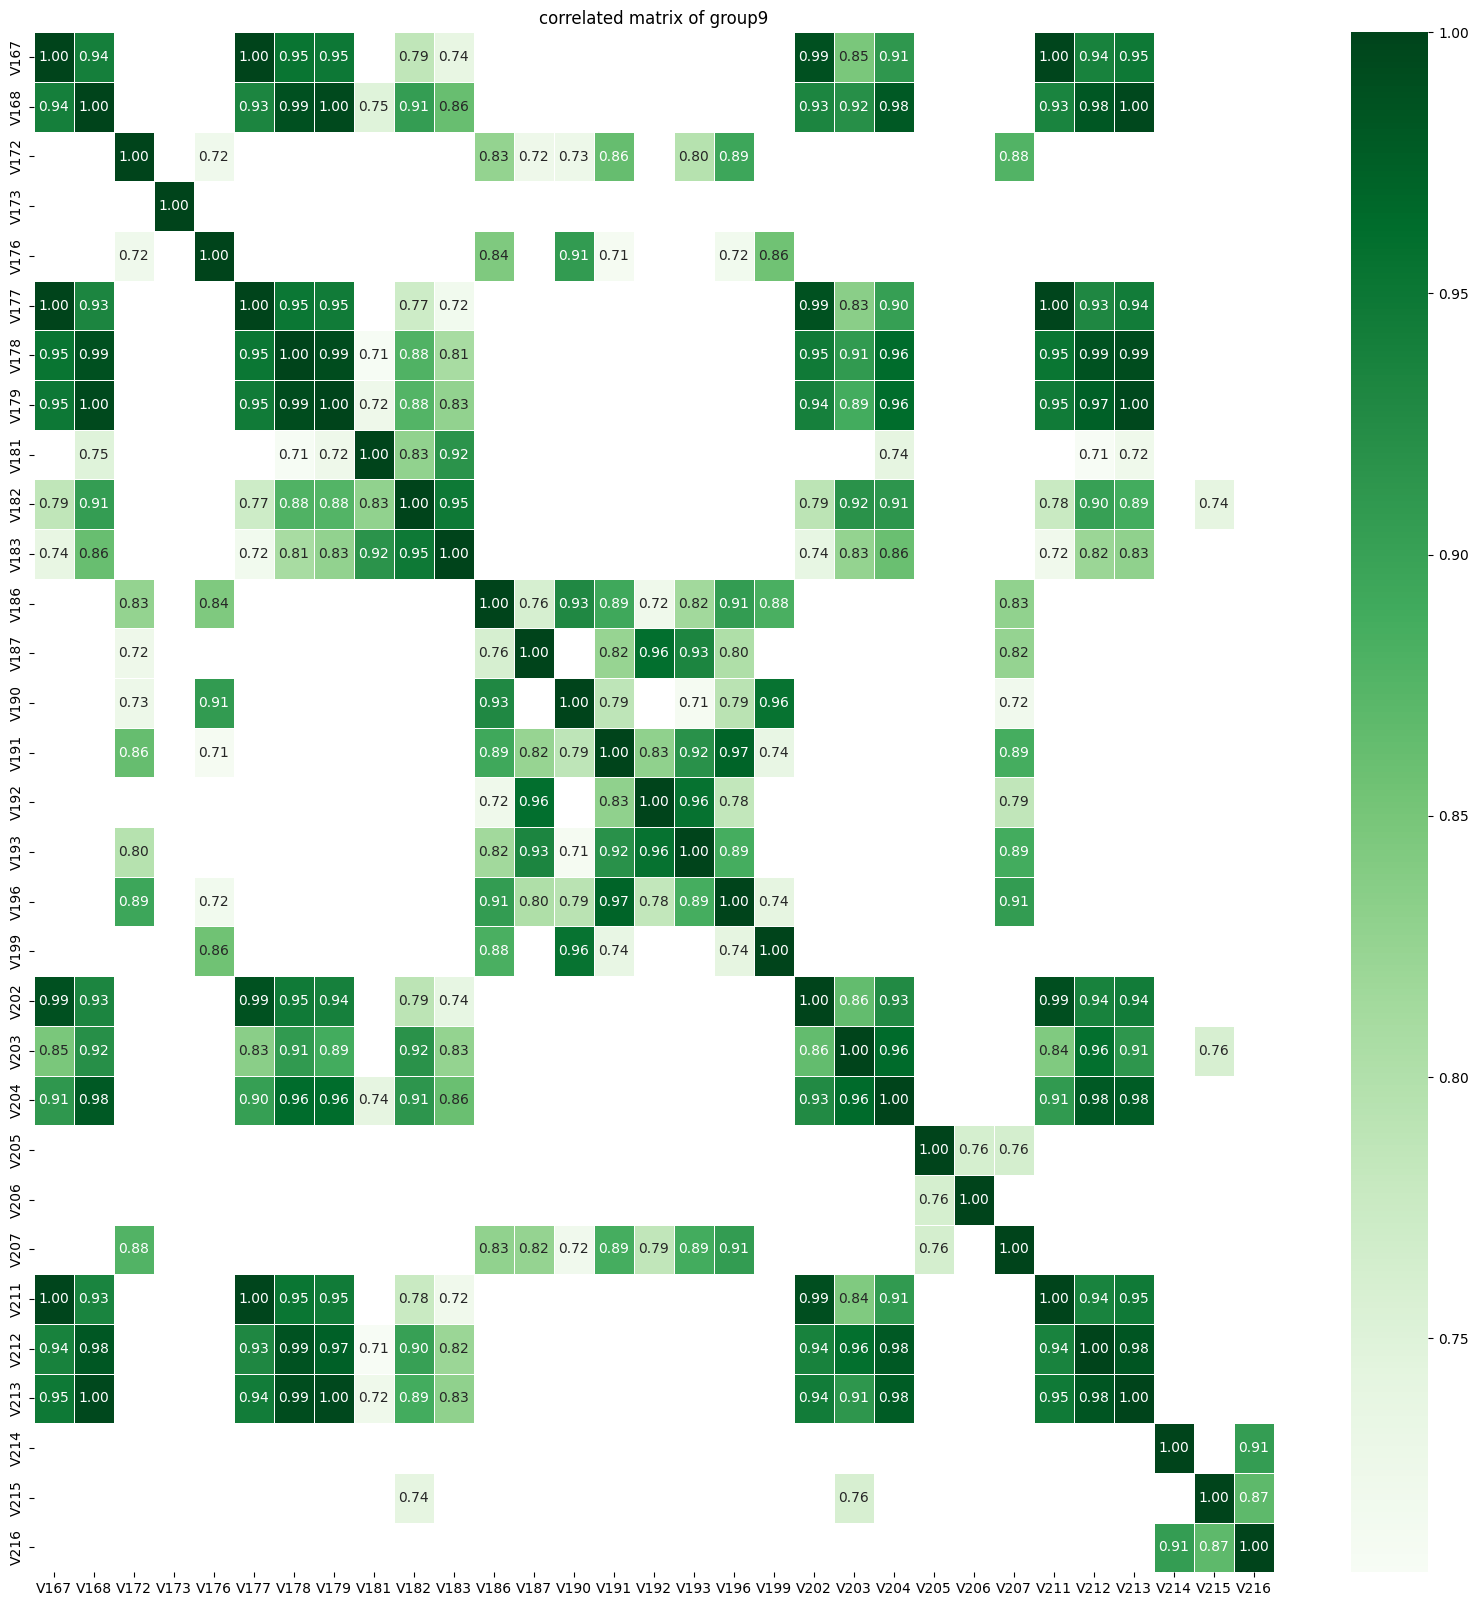

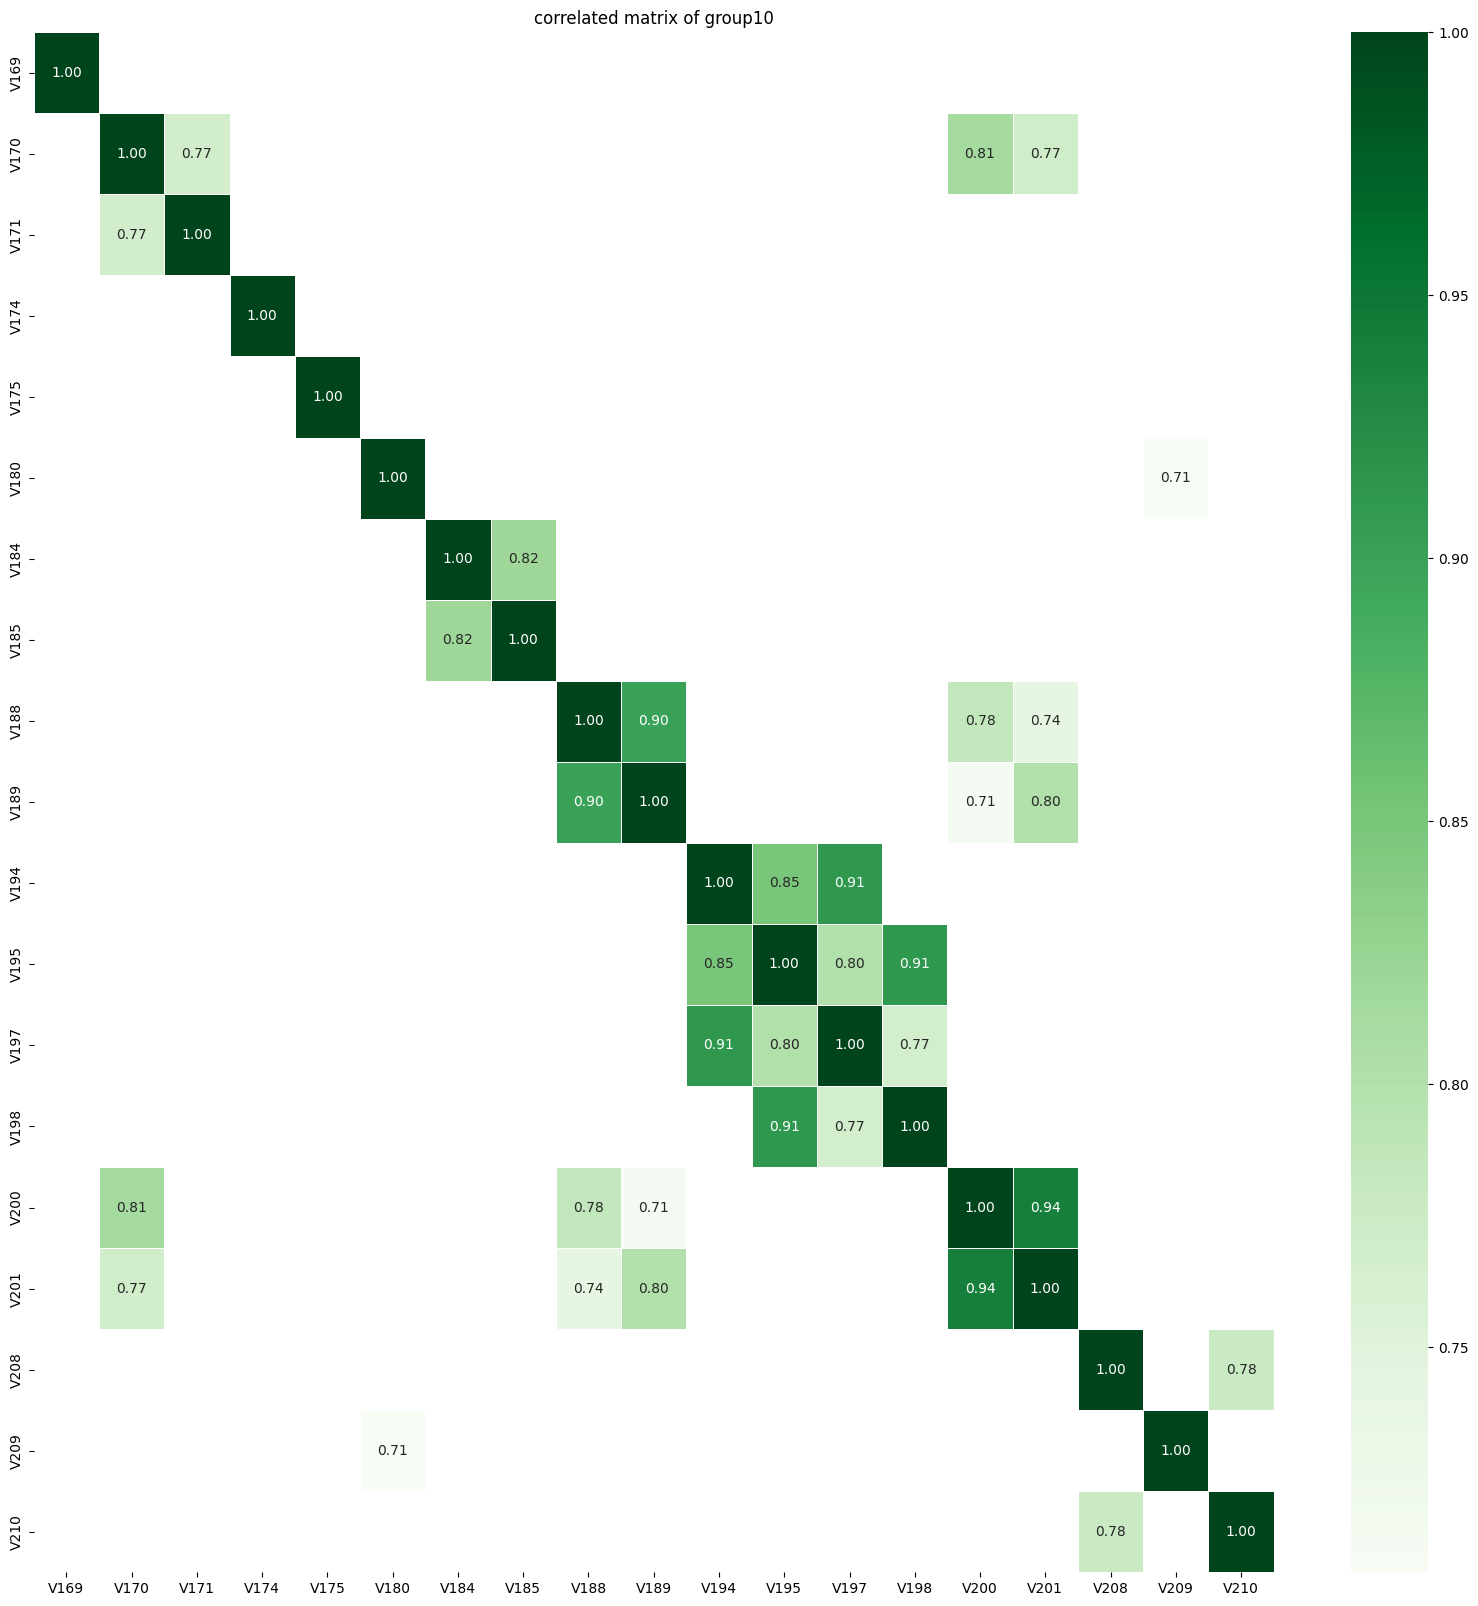

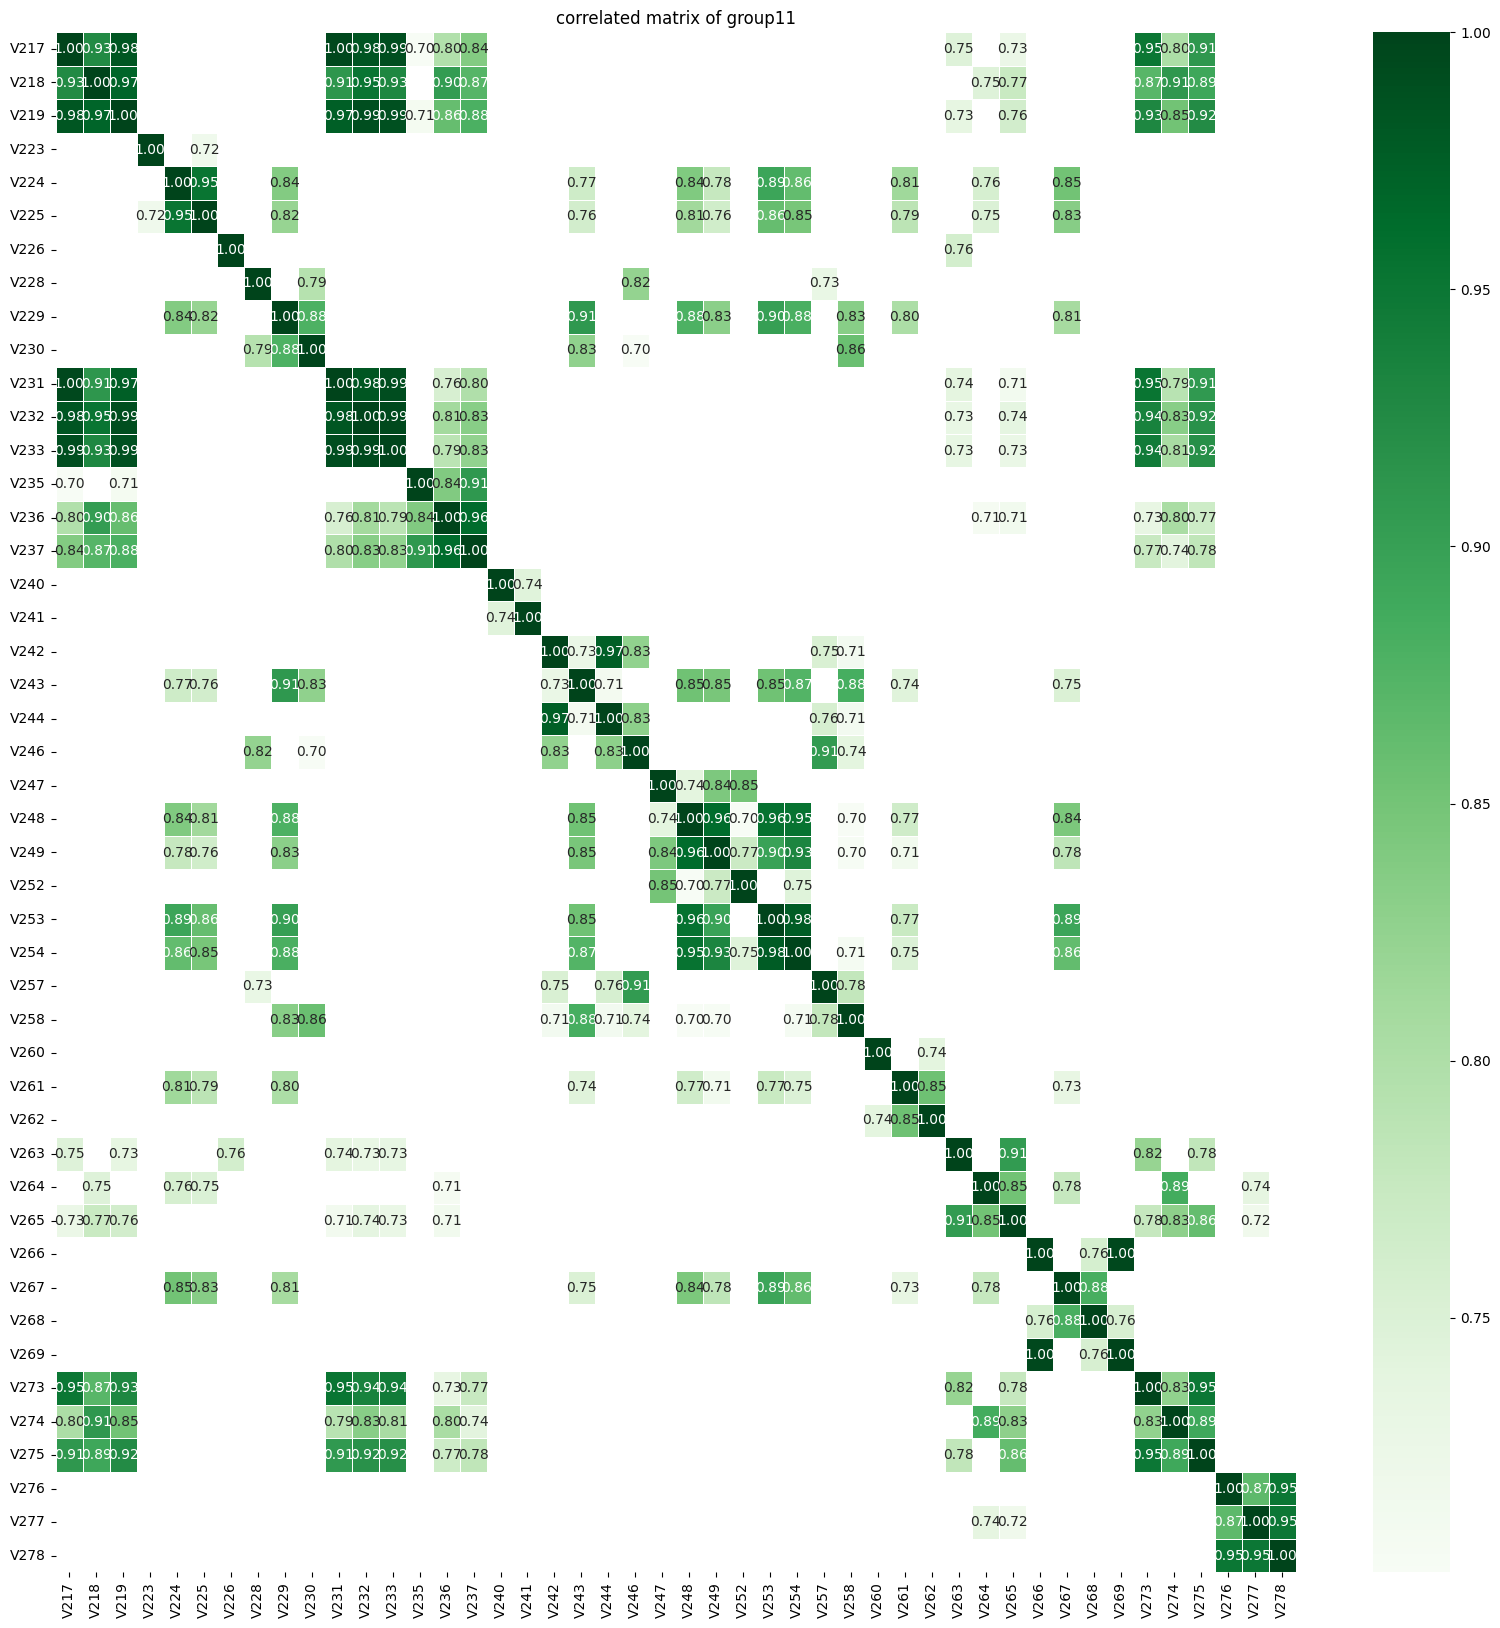

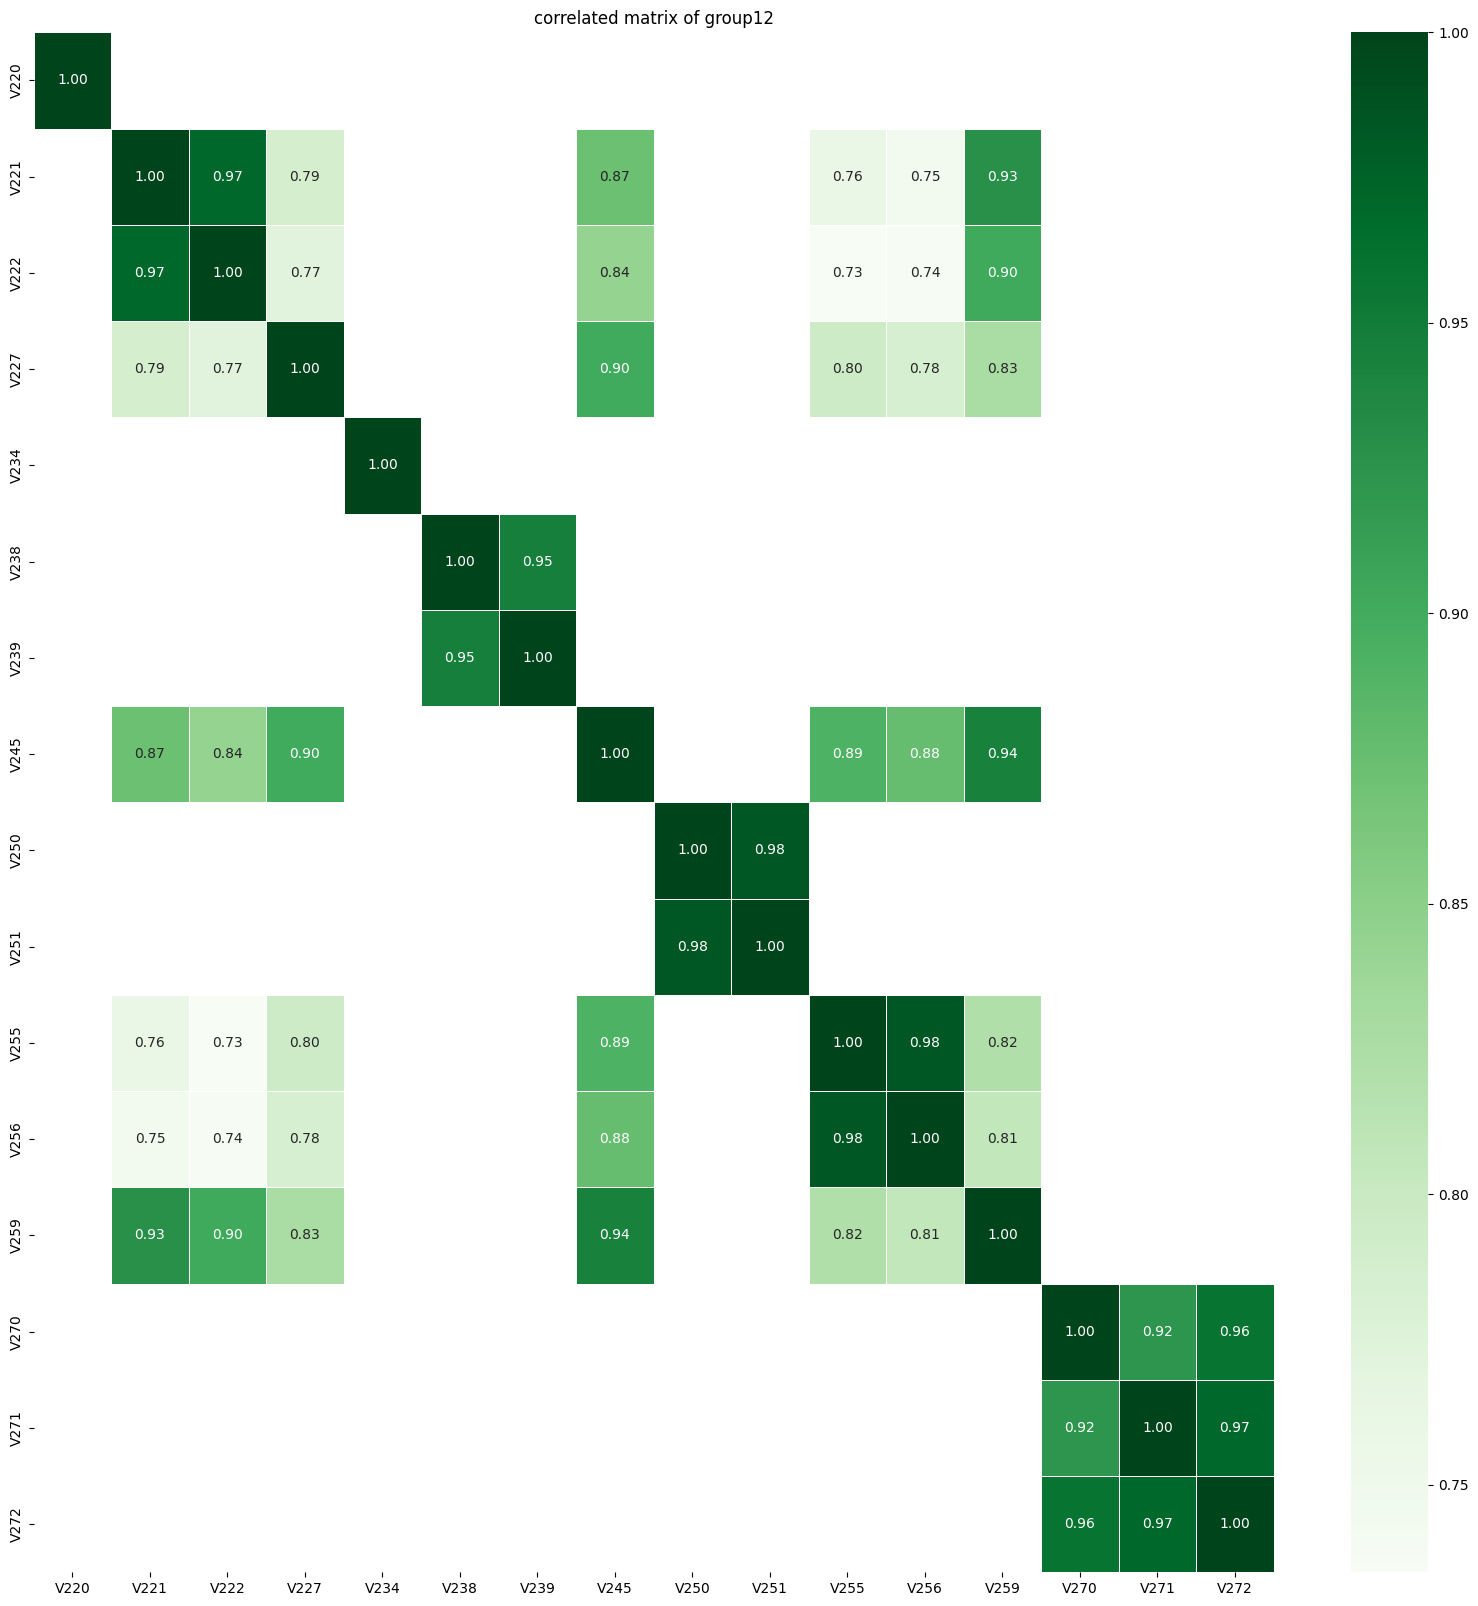

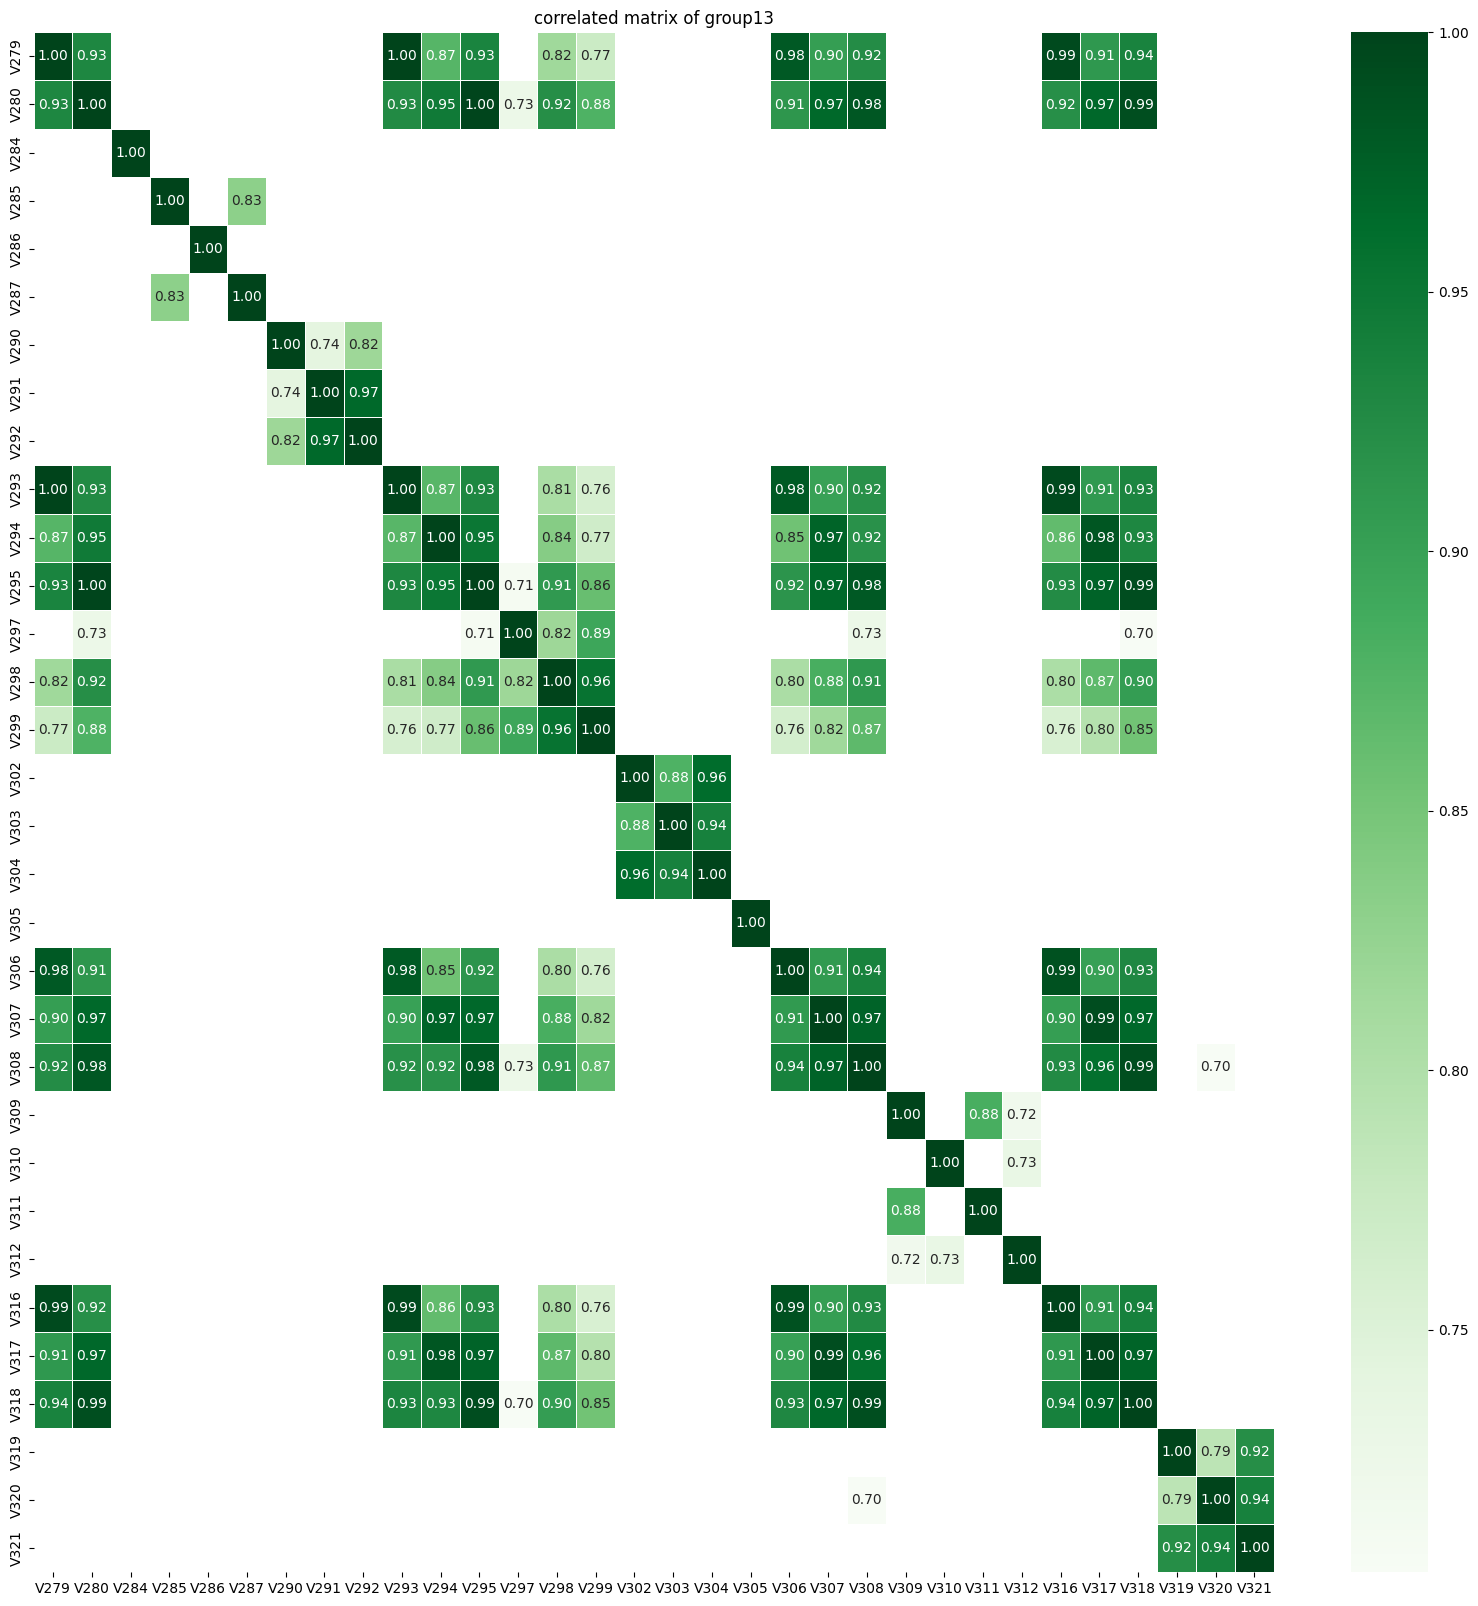

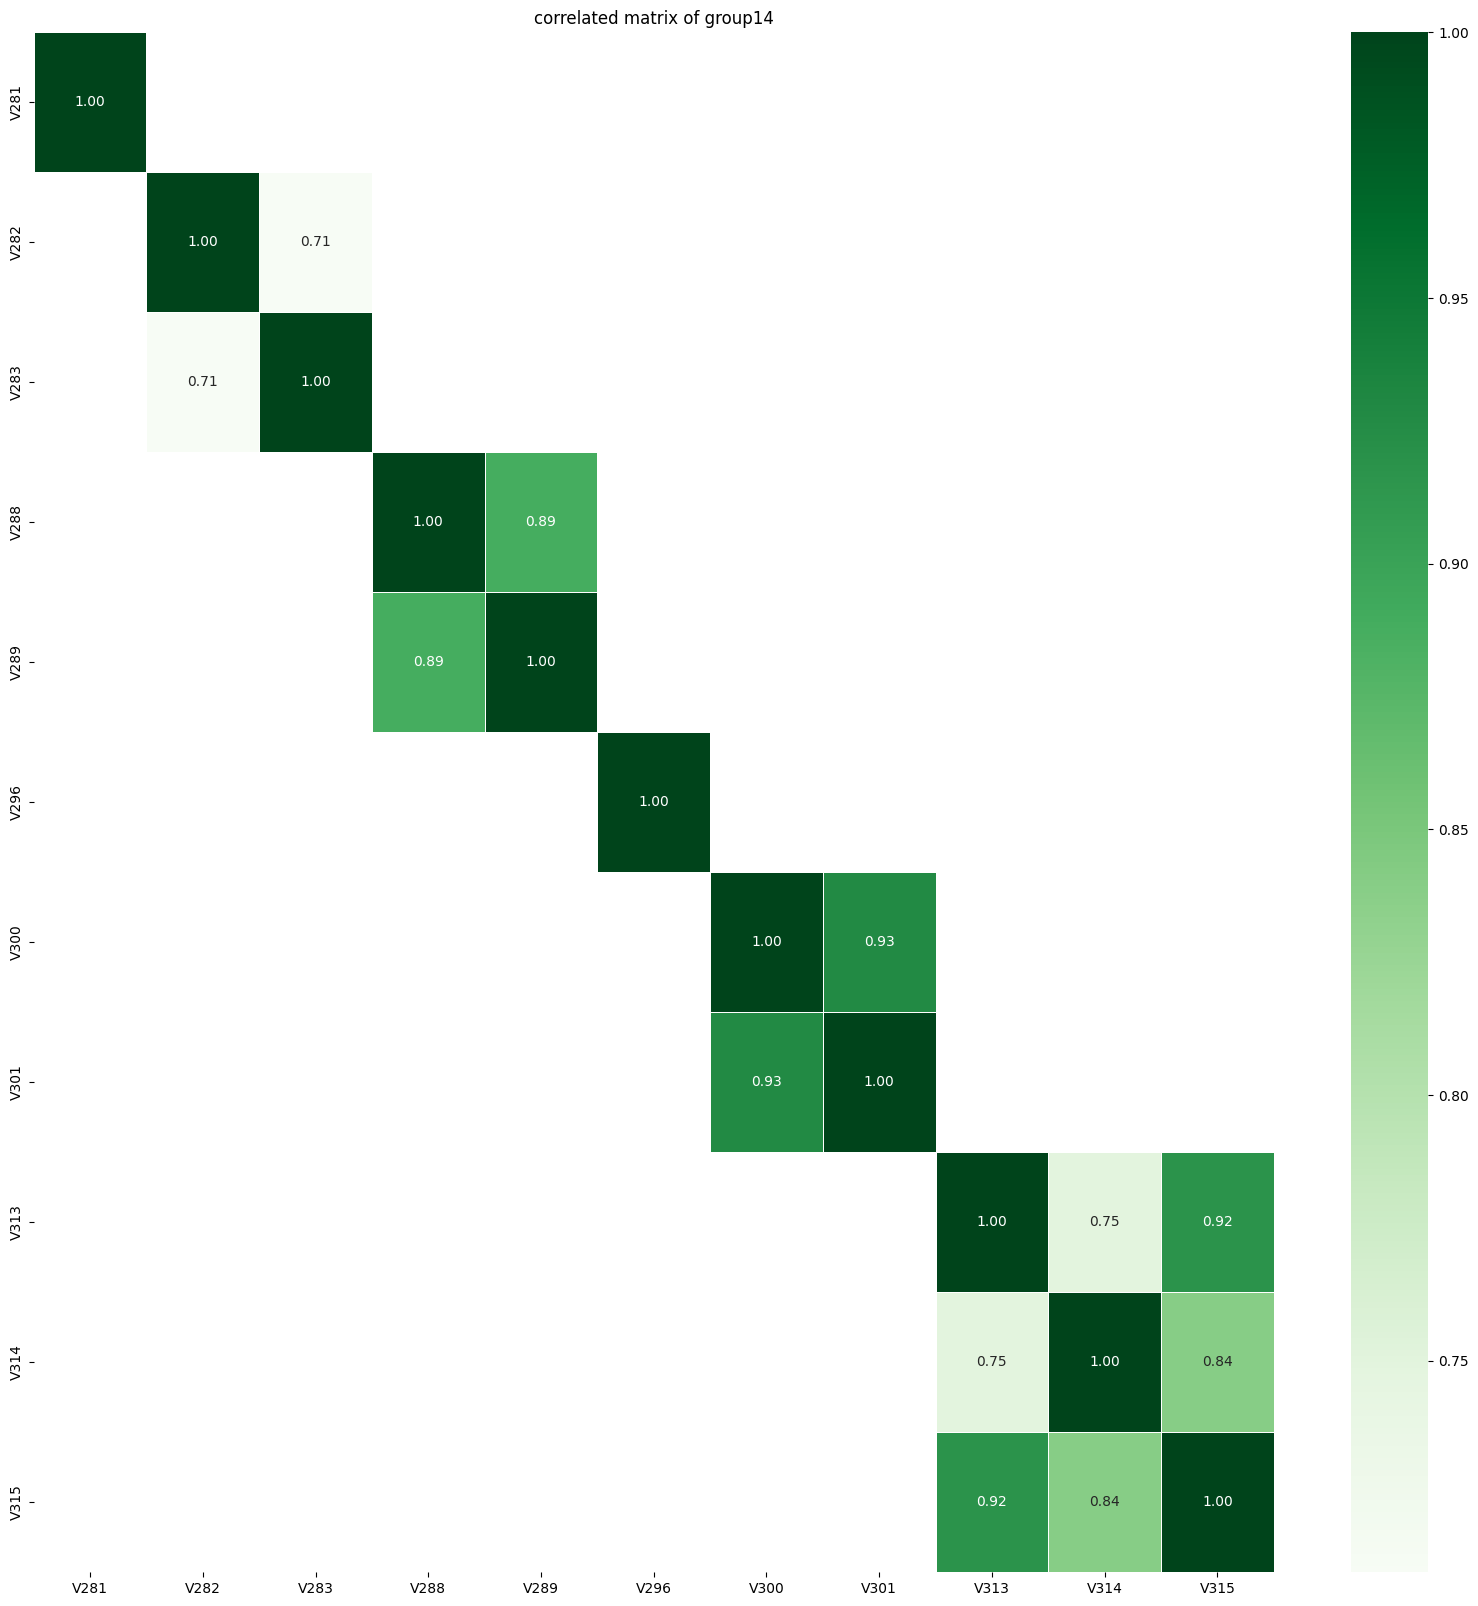

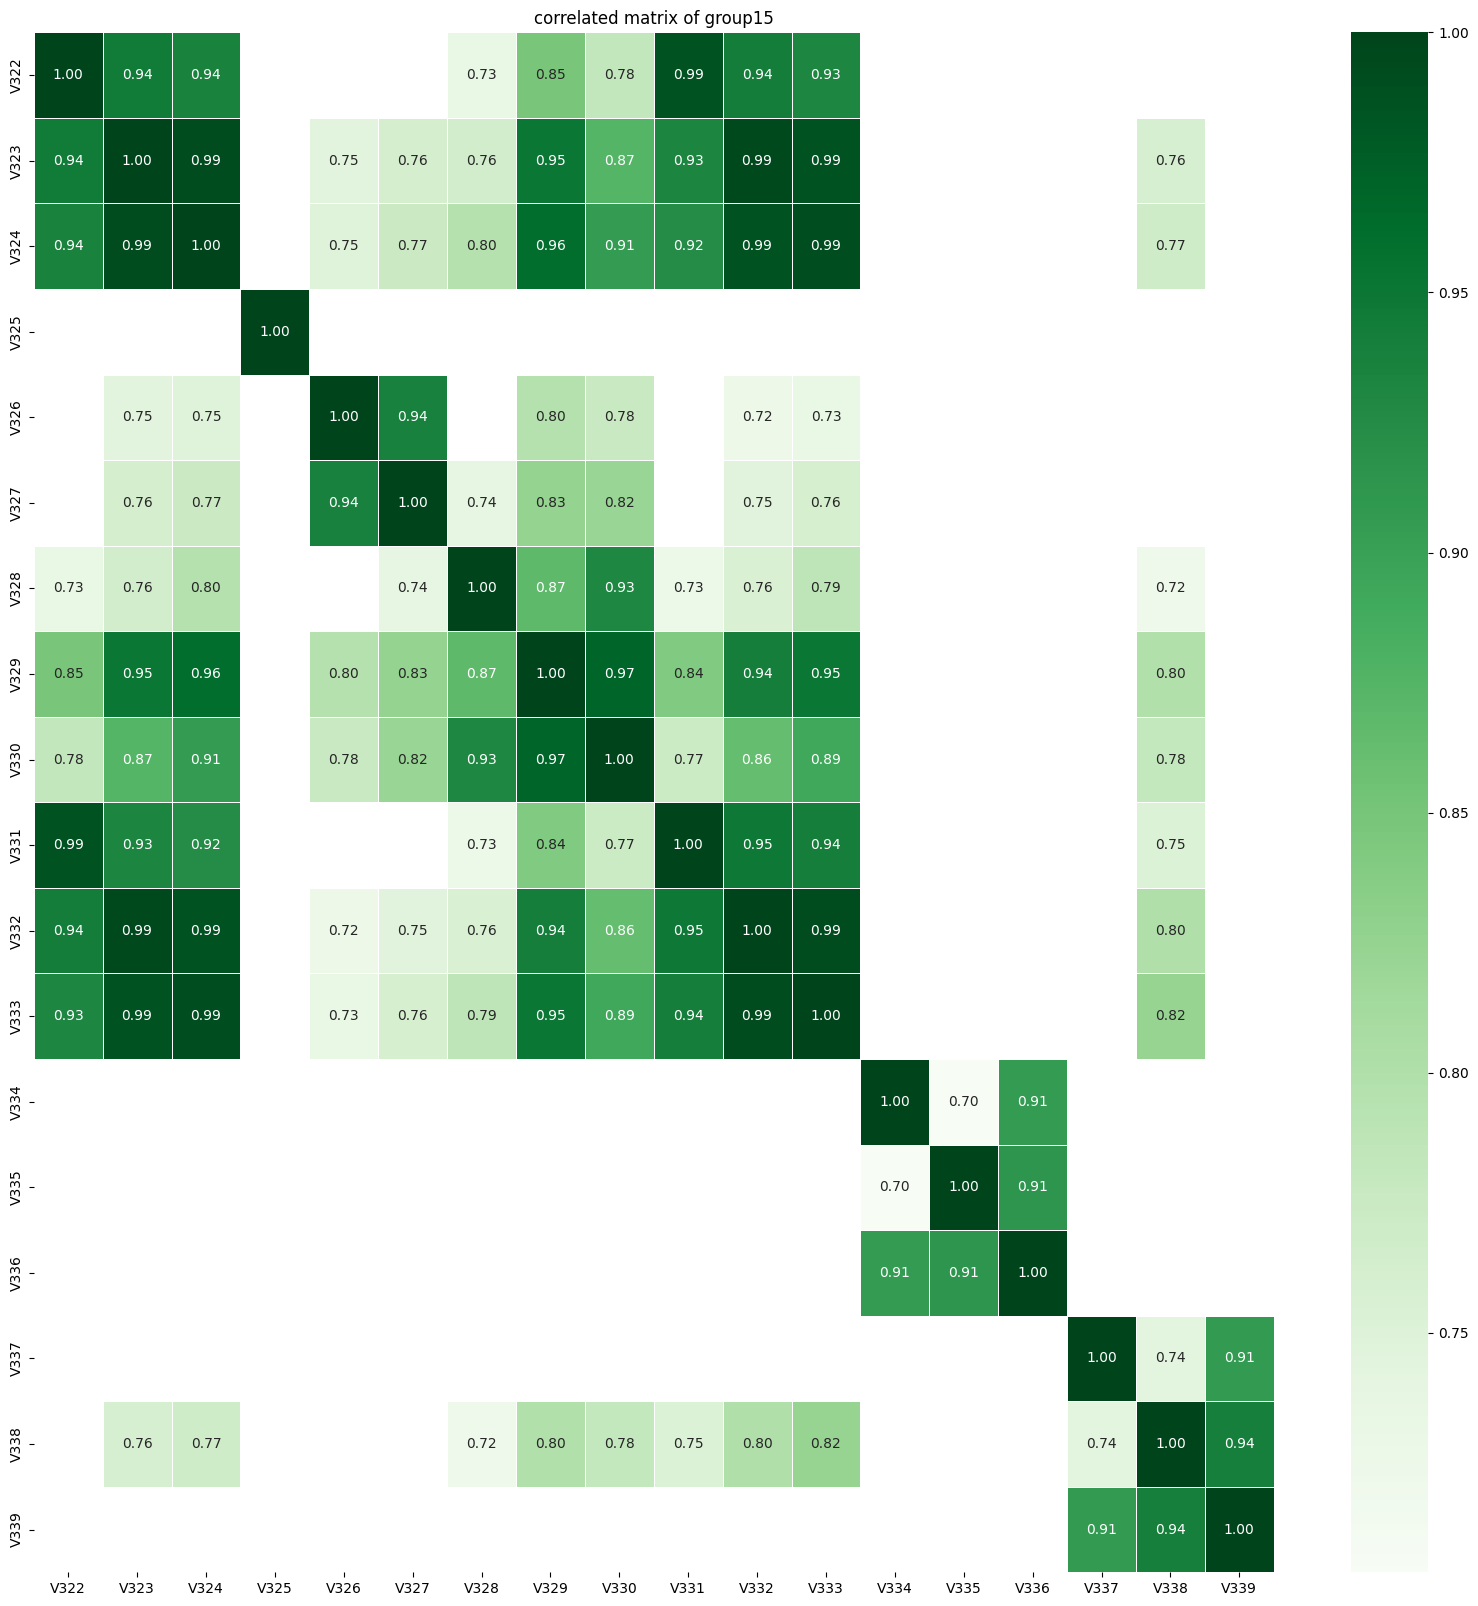

In [29]:
for i in range(len(v_grp)):
    corr = df_train[v_grp[i]].corr()
    kot = corr[corr>=.70]
    plt.figure(figsize=(20,20))
    sns.heatmap(kot, annot = True, fmt=".2f", linewidth=.5, cmap="Greens")
    print('\n')
    plt.title('correlated matrix of group' + str(i + 1))
    plt.show()

In [31]:
# forming group based on NaN values and pairing them on the basis correlation
group1 = [['V1'],['V2','V3'],['V4','V5'],['V6','V7'],['V8','V9'],['V10','V11']]
group2 = [['V12','V13'],['V14'],['V15','V16','V17','V18','V21','V22','V31','V32','V33','V34'],['V19','V20'],
         ['V23','V24'],['V25','V26'],['V27','V28'],['V29','V30']]
group3 = [['V35','V36'],['V37','V38'],['V39','V40','V42','V43','V50','V51','V52'],['V41'],
         ['V44','V45'],['V46','V47'],['V48','V49']]
group4 = [['V53','V54'],['V55'],['V56'],['V57', 'V58', 'V59', 'V60', 'V63', 'V64', 'V71', 'V72', 'V73', 'V74'],
          ['V61','V62'],['V65'],['V66','V67'],['V68'],['V69','V70']]
group5 = [['V75','V76'],['V77','V78'],['V79','V80','V81','V84','V85','V92','V93','V94'],['V82','V83'],['V86','V87'],
         ['V88'],['V89'],['V90','V91']]
group6 = [['V99','V100'],['V98'],['V104'],['V95','V96','V97','V101','V102','V103','V105','V106'],['V107'],
          ['V108','V109','V110','V114'],['V111','V112','V113'],['V115','V116'],['V117','V118','V119'],
          ['V120','V122'],['V121'],['V123'],['V124','V125'],['V126','V127','V128','V132','V133','V134'],
          ['V129'],['V130','V131'],['V135','V136','V137']]
group7 = [['V138'],['V139','V140'],['V141','V142'],['V146','V147'],['V148','V149','V153','V154','V156','V157','V158'],
          ['V161','V162','V163']]
group8 = [['V143','V164','V165'],['V144','V145','V150','V151','V152','V159','V160'],['V166']]
group9 = [['V167','V168','V177','V178','V179'],['V172','V176'],['V173'],['V181','V182','V183'],
          ['V186','V187','V190','V191','V192','V193','V196','V199'],['V202','V203','V204','V211','V212','V213'],
          ['V205','V206'],['V207'],['V214','V215','V216']]
group10 = [['V169'],['V170','V171','V200','V201'],['V174','V175'],['V180'],['V184','V185'],['V188','V189'],
           ['V194','V195','V197','V198'],['V208','V210'],['V209']]
group11 = [['V217','V218','V219','V231','V232','V233','V236','V237'],['V223'],['V224','V225'],['V226'],['V228'],
           ['V229','V230'],['V235'],['V240','V241'],['V242','V243','V244','V258'],['V246','V257'],
           ['V247','V248','V249','V253','V254'],['V252'],['V260'],['V261','V262'],['V263','V265','V264'],
           ['V266','V269'],['V267','V268'],['V273','V274','V275'],['V276','V277','V278']]
group12 = [['V220'],['V221','V222','V227','V245','V255','V256','V259'],['V234'],['V238','V239'],
           ['V250','V251'],['V270','V271','V272']]
group13 = [['V279','V280','V293','V294','V295','V298','V299'],['V284'],['V285','V287'],['V286'],
           ['V290','V291','V292'],['V297'],['V302','V303','V304'],['V305'],['V306','V307','V308','V316','V317','V318'],
           ['V309','V311'],['V310','V312'],['V319','V320','V321']]
group14 = [['V281'],['V282','V283'],['V288','V289'],['V296'],['V300','V301'],['V313','V314','V315']]
group15 = [['V322','V323','V324','V326','V327','V328','V329','V330','V331','V332','V333'],['V325'],
           ['V334','V335','V336'],['V337','V338','V339']]

In [32]:
# Above results give us the subgroups within the groups, now from these subgroups we will choose only that feature which has the most unique value since it holds the maximum information

total_groups = [group1, group2, group3, group4, group5, group6, group7, group8, 
                group9, group10, group11, group12, group13, group14, group15]

selected_v_features = []

for grp in total_groups:
    selected_v_features += reduce_groups(grp)

In [33]:
print(selected_v_features)

['V1', 'V3', 'V4', 'V6', 'V8', 'V11', 'V13', 'V14', 'V17', 'V20', 'V23', 'V26', 'V27', 'V30', 'V36', 'V37', 'V40', 'V41', 'V44', 'V47', 'V48', 'V54', 'V55', 'V56', 'V59', 'V62', 'V65', 'V67', 'V68', 'V70', 'V76', 'V78', 'V80', 'V82', 'V86', 'V88', 'V89', 'V91', 'V99', 'V98', 'V104', 'V96', 'V107', 'V108', 'V111', 'V115', 'V117', 'V120', 'V121', 'V123', 'V124', 'V127', 'V129', 'V130', 'V136', 'V138', 'V139', 'V142', 'V147', 'V156', 'V162', 'V165', 'V160', 'V166', 'V178', 'V176', 'V173', 'V182', 'V187', 'V203', 'V205', 'V207', 'V215', 'V169', 'V171', 'V175', 'V180', 'V185', 'V188', 'V198', 'V210', 'V209', 'V218', 'V223', 'V224', 'V226', 'V228', 'V229', 'V235', 'V240', 'V258', 'V257', 'V253', 'V252', 'V260', 'V261', 'V264', 'V266', 'V267', 'V274', 'V277', 'V220', 'V221', 'V234', 'V238', 'V250', 'V271', 'V294', 'V284', 'V285', 'V286', 'V291', 'V297', 'V303', 'V305', 'V307', 'V309', 'V310', 'V320', 'V281', 'V283', 'V289', 'V296', 'V301', 'V314', 'V332', 'V325', 'V335', 'V338']


In [34]:
to_drop_v_fea = list(set(v_features) - set(selected_v_features))

In [35]:
print(to_drop_v_fea)

['V197', 'V152', 'V157', 'V269', 'V194', 'V242', 'V22', 'V109', 'V273', 'V243', 'V292', 'V97', 'V5', 'V53', 'V268', 'V326', 'V144', 'V163', 'V255', 'V222', 'V32', 'V102', 'V241', 'V211', 'V57', 'V172', 'V170', 'V50', 'V282', 'V16', 'V114', 'V190', 'V155', 'V245', 'V191', 'V186', 'V151', 'V106', 'V298', 'V10', 'V9', 'V189', 'V330', 'V79', 'V227', 'V143', 'V233', 'V248', 'V15', 'V278', 'V31', 'V74', 'V134', 'V24', 'V204', 'V137', 'V244', 'V87', 'V75', 'V145', 'V101', 'V272', 'V7', 'V63', 'V167', 'V293', 'V128', 'V52', 'V201', 'V46', 'V69', 'V334', 'V19', 'V206', 'V43', 'V317', 'V39', 'V141', 'V28', 'V38', 'V254', 'V164', 'V29', 'V270', 'V225', 'V287', 'V337', 'V333', 'V158', 'V311', 'V263', 'V66', 'V60', 'V236', 'V200', 'V61', 'V312', 'V299', 'V72', 'V256', 'V306', 'V49', 'V319', 'V275', 'V214', 'V279', 'V231', 'V202', 'V247', 'V339', 'V132', 'V196', 'V208', 'V113', 'V125', 'V216', 'V280', 'V313', 'V318', 'V119', 'V77', 'V94', 'V249', 'V288', 'V193', 'V323', 'V290', 'V300', 'V64', 'V92',

In [36]:
df_train.drop(to_drop_v_fea, axis=1, inplace=True)
df_test.drop(to_drop_v_fea, axis=1, inplace=True)

In [37]:
# Saving the Datasets

df_train.to_pickle('/content/drive/MyDrive/Self_Case_Study_1/Datasets/feature_engg/basic_clean_train.pkl')
df_test.to_pickle('/content/drive/MyDrive/Self_Case_Study_1/Datasets/feature_engg/basic_clean_test.pkl')

In [38]:
print('shape of training dataset:', df_train.shape)
print('shape of test dataset:', df_test.shape)

shape of training dataset: (590540, 224)
shape of test dataset: (506691, 223)


**Assessing the fundamentally cleaned dataset using test data & tuned hyperparameters**

**Cross-Validation**

In [39]:
X = df_train.drop(['isFraud', 'TransactionID'], axis=1)
y = df_train['isFraud']

# splitting training dataset into train and cv
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.20, random_state=10) 
del X, y

In [40]:
print('shape of training dataset:', X_train.shape)
print('shape of test dataset:', X_cv.shape)

shape of training dataset: (472432, 222)
shape of test dataset: (118108, 222)


In [41]:
# Label Encoding Categorical Features
X_train, X_cv = label_encoding(X_train, X_cv, cat_fea)

# Normalizing numerical features
X_train_norm, X_cv_norm = min_max_scaler(X_train, X_cv)

In [42]:
# fitting the inital model on tuned parameters
xgboost = XGBClassifier(
          objective='binary:logistic',
          eval_metric='auc',
          n_estimators=1000,
          tree_method='gpu_hist',
          random_state=10,
          subsample=0.8,
          max_depth=20,
          colsample_bytree=0.4,
          learning_rate=0.2,
          missing=-1
          )

xgboost.fit(X_train_norm, y_train, eval_set=[(X_cv_norm, y_cv)], verbose=50, early_stopping_rounds=100)
score = roc_auc_score(y_cv, xgboost.predict_proba(X_cv_norm)[:,1])

[0]	validation_0-auc:0.85314
[50]	validation_0-auc:0.96934
[100]	validation_0-auc:0.97211
[150]	validation_0-auc:0.97317
[200]	validation_0-auc:0.97336
[250]	validation_0-auc:0.97340
[300]	validation_0-auc:0.97344
[316]	validation_0-auc:0.97339


In [45]:
print(f'cross-validation score: {score}')

cross-validation score: 0.9735307029336584


In [46]:
y_train_pred = xgboost.predict(X_train_norm)
y_cv_pred = xgboost.predict(X_cv_norm)

train_fpr, train_tpr, thresholds = roc_curve(y_train, xgboost.predict_proba(X_train_norm)[:,1])
cv_fpr, cv_tpr, thresholds = roc_curve(y_cv, xgboost.predict_proba(X_cv_norm)[:,1])

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(cv_fpr, cv_tpr)))

Area under train roc 0.99999999960068
Area under test roc 0.9735307029336584


Train Confusion Matrix:
[[455955      0]
 [    17  16460]]


<Axes: >

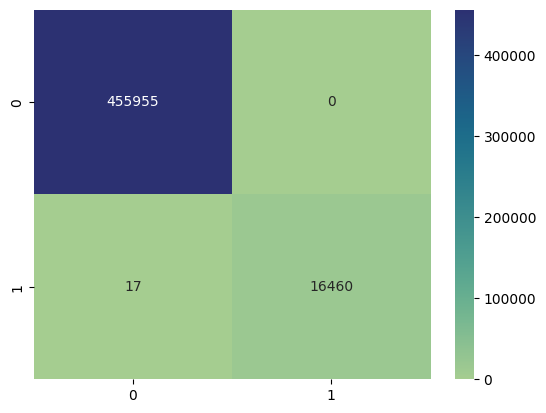

In [47]:
# Plotting train confusion matrix
print("Train Confusion Matrix:")
cf_matrix_train = confusion_matrix(y_train, y_train_pred)
print(cf_matrix_train)
sns.heatmap(cf_matrix_train, annot=True, fmt= "", cmap='crest')

CV Confusion Matrix:
[[113851     71]
 [  1469   2717]]


<Axes: >

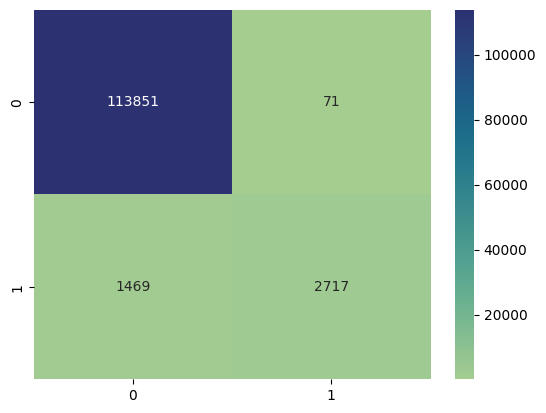

In [48]:
# Plotting test confusion matrix
print("CV Confusion Matrix:")
cf_matrix_cv = confusion_matrix(y_cv, y_cv_pred)
print(cf_matrix_cv)
sns.heatmap(cf_matrix_cv, annot=True, fmt= "", cmap='crest')

**Evaluation on Test data**

Splitting the dataset into train and test

In [49]:
X_train = df_train.drop(['isFraud', 'TransactionID'], axis=1)
y_train = df_train['isFraud']

X_test = df_test.drop(['TransactionID'], axis=1)
test_ids = df_test['TransactionID'].values

del df_train, df_test

In [50]:
print('shape of training dataset:', X_train.shape)
print('shape of test dataset:', X_test.shape)

shape of training dataset: (590540, 222)
shape of test dataset: (506691, 222)


In [51]:
# Label Encoding Categorical Features
X_train, X_test = label_encoding(X_train, X_test, cat_fea)

# Normalizing numerical features
X_train_norm, X_test_norm = min_max_scaler(X_train, X_test)

In [52]:
xgboost = XGBClassifier(
          objective='binary:logistic',
          eval_metric='auc',
          n_estimators=1000,
          tree_method='gpu_hist',
          random_state=10,
          subsample=0.8,
          max_depth=20,
          colsample_bytree=0.4,
          learning_rate=0.2,
          missing=-1
          )

xgboost.fit(X_train_norm, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.4, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=20, max_leaves=None,
              min_child_weight=None, missing=-1, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=10, ...)

In [53]:
xgboost_test_proba = xgboost.predict_proba(X_test_norm)[:,1]
predict_and_save(xgboost_test_proba, '/content/drive/MyDrive/Self_Case_Study_1/ipynb/to_predict/xgboost_test1.csv')

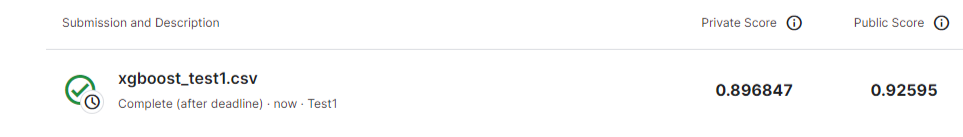